In [74]:
from math import floor
import numpy as np
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import colors
%matplotlib inline

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False,max_steps=100):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.wind = wind
        self.max_steps=max_steps

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward
        self.grid=np.zeros((self.num_rows,self.num_cols))
        for arr in self.goal_states:
          self.grid[arr[0],arr[1]]=4
        for arr in self.obs_states:
          self.grid[arr[0],arr[1]]=3
        for arr in self.bad_states:
          self.grid[arr[0],arr[1]]=2
        for arr in self.restart_states:
          self.grid[arr[0],arr[1]]=1

    def render(self,state,render_agent=False,ax=None):
      grid=self.grid.copy()
      x_y=seq_to_col_row(state,self.num_cols)
      if render_agent:
        grid[x_y[0][0],x_y[0][1]]=5
      plt.clf()
      cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00'])
      if ax is None:
        fig, ax = plt.subplots()
      ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)





    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      self.steps=0
      self.done=False
      return int(self.start_state_seq)
      
    def step(self, state, action):
        self.steps+=1
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if next_next in self.goal_states_seq or self.steps>=self.max_steps:
            self.done=True
            
          return next_next, self.R[next_next],self.done
        else:
          if next_state in self.goal_states_seq or self.steps>=self.max_steps:
            self.done=True
          return next_state, self.R[next_state],self.done

In [75]:
DOWN = 1
UP = 0
LEFT = 2
RIGHT = 3
def plot_Q(Q, message = "Q plot"):
    Q2=np.zeros((num_rows,num_cols, env.num_actions))
    for i in range(Q.shape[0]):
      x_y=seq_to_col_row(i,num_cols)
      Q2[x_y[0][0],x_y[0][1]]=Q[i,:]
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q2.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return -1 if a == UP else 1
    policy = Q2.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

In [76]:
num_cols = 10
num_rows = 10
episodes = 5000

In [77]:
def create_env(wind=True,p=1,start_state=[3,6]):
  
  num_cols = 10
  num_rows = 10
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                           [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                           [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                           [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  start_state = np.array([start_state])
  goal_states = np.array([[0,9],[2,2],[8,7]])
  gw = GridWorld(num_rows=num_rows,
                 num_cols=num_cols,
                 start_state=start_state,
                 goal_states=goal_states, wind = wind)
  gw.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)
  gw.add_rewards(step_reward=-1,
                 goal_reward=10,
                 bad_state_reward=-6,
                 restart_state_reward=-10)
  gw.add_transition_probability(p_good_transition=p,
                                bias=0.5)
  env = gw.create_gridworld()
  return env

In [92]:
from scipy.special import softmax



def choose_action_epsilon(Q, state, epsilon):
  
    if np.random.rand()<epsilon: 
        
        return  np.random.choice(4) 
    else:

        return  np.argmax(Q[state])

def choose_action_softmax(Q, state, tau):

    action_prob=softmax(Q[state]/tau)
    action=np.random.choice(4,p=action_prob)

    return action

In [79]:
print_freq = 500

def sarsa(env, Q, alpha0,gamma,epsilon=0.1,tau=0.01, plot_heat = False, strategy = 'softmax'):


    state_his=np.zeros((num_rows,num_cols))
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        state = env.reset()
        x_y=seq_to_col_row(state,num_cols)[0]
        state_his[x_y[0],x_y[1]]+=1
        if strategy=='softmax':
          action = choose_action_softmax(Q, state,tau)
        else:
          action=choose_action_epsilon(Q, state, epsilon)
        done = False
        while not done:
            state_next, reward, done= env.step(state,action)
            if strategy=='softmax':
              action_next = choose_action_softmax(Q, state,tau)
            else:
              action_next=choose_action_epsilon(Q, state, epsilon)
            
            Q[state,action]+=alpha0*(reward+gamma* Q[state_next,action_next]-Q[state,action])             
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
            x_y=seq_to_col_row(state,num_cols)[0]
            state_his[x_y[0],x_y[1]]+=1
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Heatmap of Q-values after training")
        if plot_heat and ep+1==episodes:
          plt.figure(figsize=(10,10))
          plt.title('Heatmap of state visit counts')
          plt.pcolor(state_his, edgecolors='k', linewidths=2)
          plt.colorbar()
          plt.show()
                
    return Q, episode_rewards, steps_to_completion

In [80]:
def plot_curves(env, gamma,alpha0,strategy='softmax',tau=0.01,epsilon=0.1):
  num_expts = 5
  reward_avgs, steps_avgs = np.zeros(episodes), np.zeros(episodes)
  
  for i in range(num_expts):
      print("Experiment: %d"%(i+1))
      Q = np.zeros((num_cols*num_rows, env.num_actions))
      _, rewards, steps = sarsa(env, Q, gamma = gamma,alpha0=alpha0,tau=tau,epsilon=epsilon, plot_heat=False, strategy=strategy)
      reward_avgs+=rewards/num_expts
      steps_avgs+=steps/num_expts
  plt.figure()
  plt.xlabel('Episode')
  plt.ylabel('Number of steps to Goal')
  plt.plot(np.arange(episodes),steps_avgs)
  plt.show()
  
  plt.figure()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(np.arange(episodes),reward_avgs)
  plt.show()


##The hyperparameter values were chosen on the basis of a grid search done for some of the specific cases, such as with or without wind; softmax or epsilon greedy, etc. The grid search results are shown at the last.

#$Start\:state=[3,6],\:Softmax\:exploration, Wind=False\:and\:p=1$

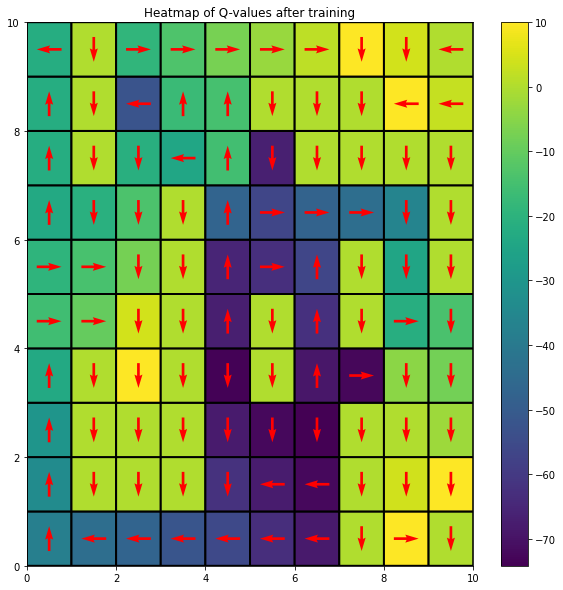

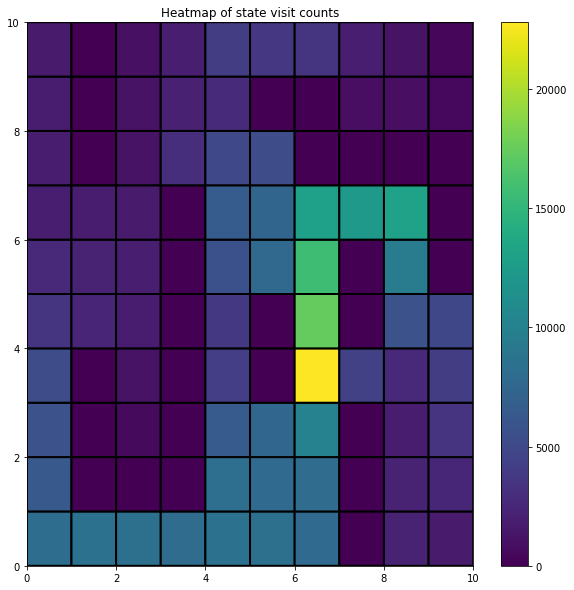

100%|██████████| 5000/5000 [01:02<00:00, 80.13it/s] 


Experiment: 1


100%|██████████| 5000/5000 [00:58<00:00, 85.65it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:58<00:00, 85.40it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:57<00:00, 86.85it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:56<00:00, 87.95it/s] 


Experiment: 5


100%|██████████| 5000/5000 [00:54<00:00, 91.44it/s] 


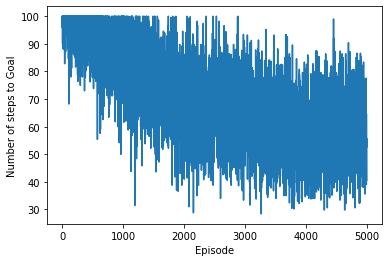

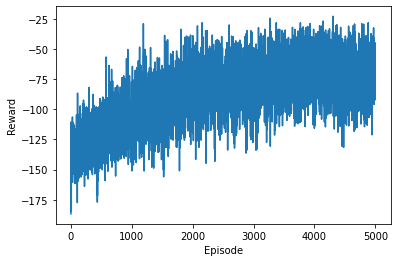

In [ ]:
gamma=1
tau=10
alpha=0.05
env=create_env(wind=False,p=1,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')



#$Start\:state=[3,6],\:Softmax\:exploration, Wind=False\:and\:p=0.7$

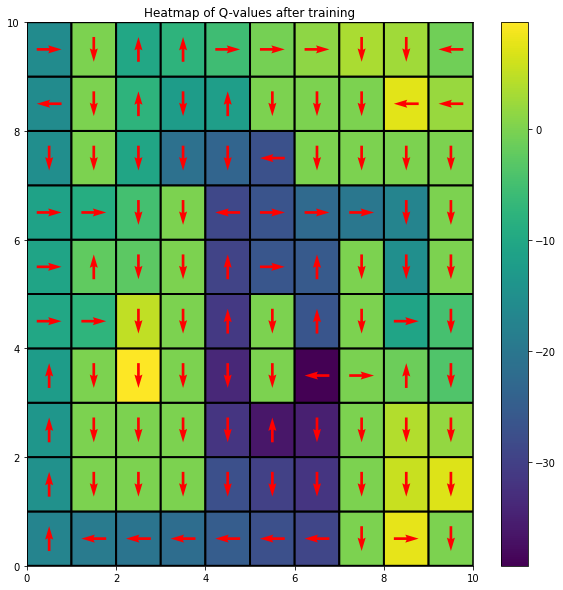

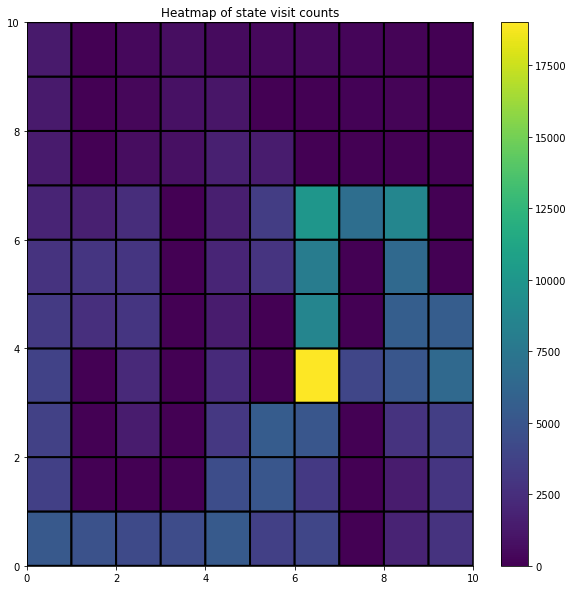

100%|██████████| 5000/5000 [00:41<00:00, 121.92it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:33<00:00, 149.93it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:33<00:00, 149.83it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:38<00:00, 129.07it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:35<00:00, 139.33it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:34<00:00, 144.95it/s]


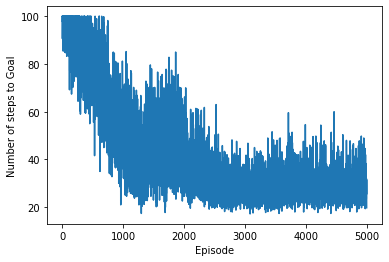

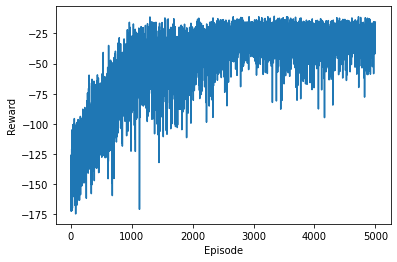

In [83]:
gamma=1
tau=0.1
alpha=0.05
env=create_env(wind=False,p=0.7,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')

#$Start\:state=[3,6],\:Softmax\:exploration, Wind=True\:and\:p=1$

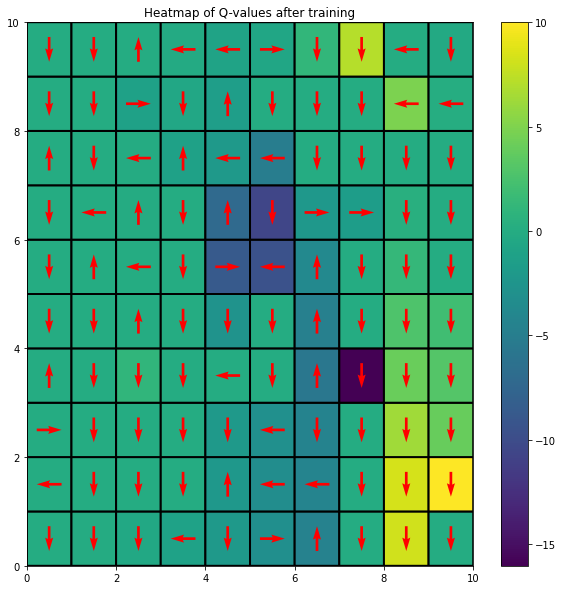

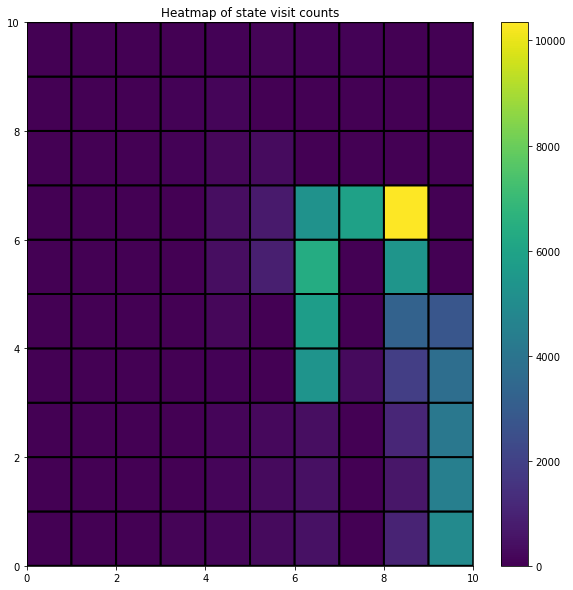

100%|██████████| 5000/5000 [00:16<00:00, 296.79it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 362.24it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:14<00:00, 337.18it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:13<00:00, 372.72it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:15<00:00, 318.92it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:13<00:00, 362.32it/s]


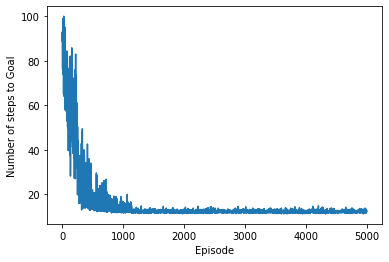

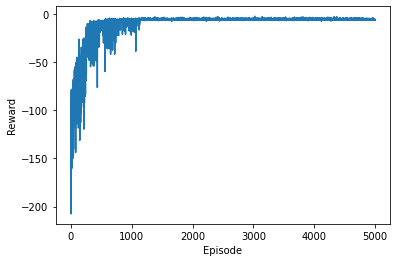

In [85]:
gamma=1
tau=0.1
alpha=0.05
env=create_env(wind=True,p=1,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')

#$Start\:state=[3,6],\:Softmax\:exploration, Wind=True\:and\:p=0.7$

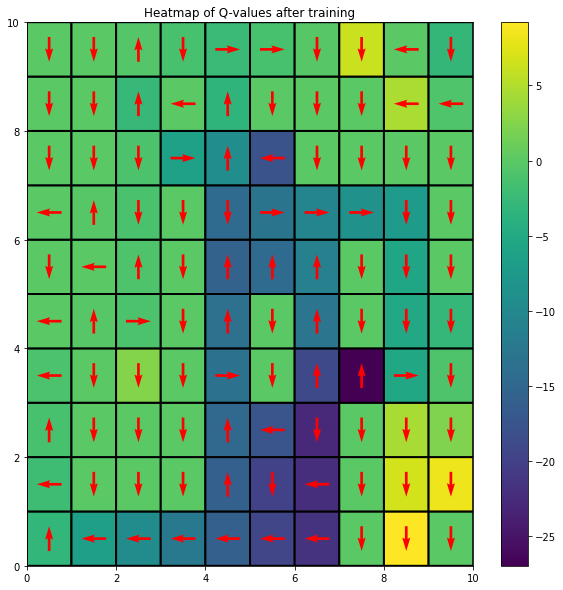

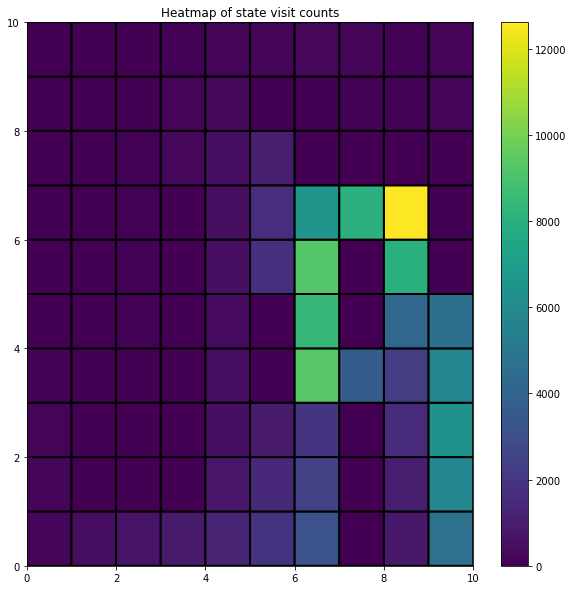

100%|██████████| 5000/5000 [00:25<00:00, 193.46it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:21<00:00, 228.83it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:21<00:00, 230.62it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:21<00:00, 229.89it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:22<00:00, 219.09it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:21<00:00, 235.30it/s]


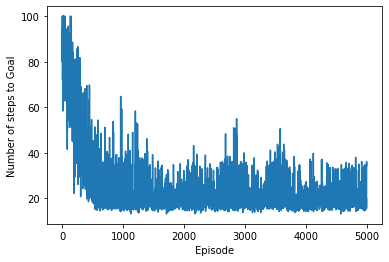

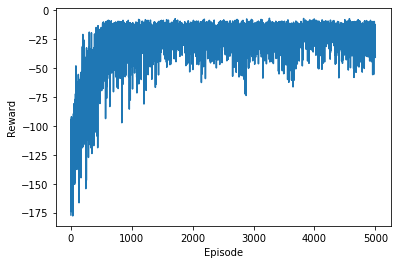

In [86]:
gamma=1
tau=0.1
alpha=0.05
env=create_env(wind=True,p=0.7,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')

#$Start\:state=[3,6],\:ϵ-greedy\:exploration, Wind=True\:and\:p=0.7$

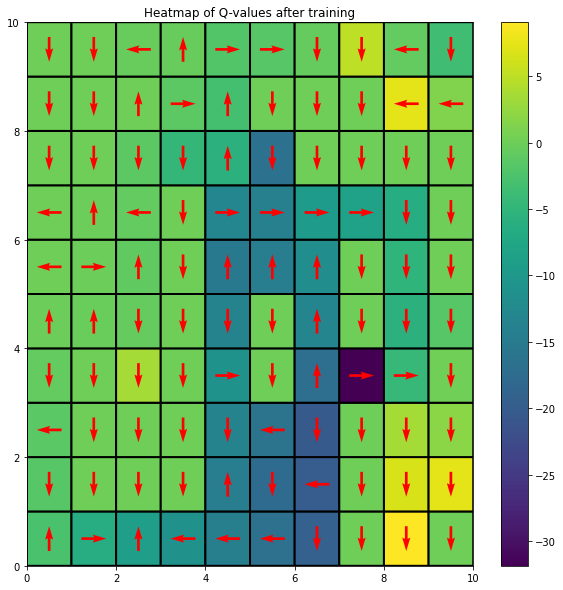

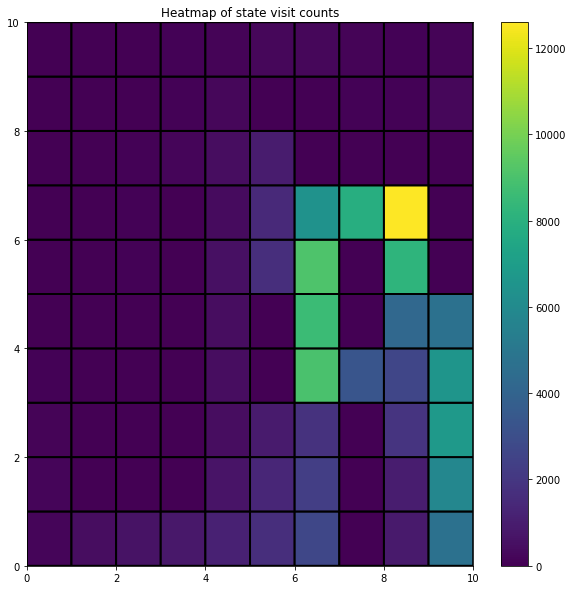

100%|██████████| 5000/5000 [00:14<00:00, 340.90it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 468.26it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 472.42it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 451.53it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:10<00:00, 481.44it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:10<00:00, 455.02it/s]


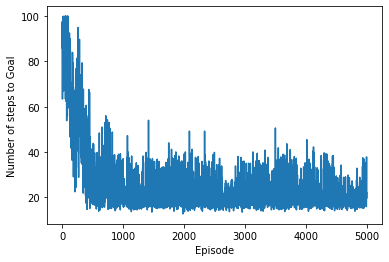

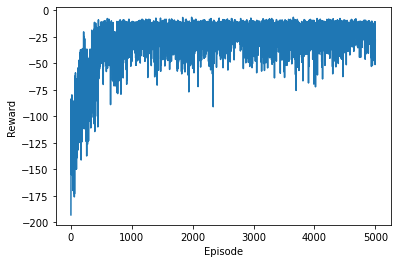

In [93]:
gamma=1
epsilon=0.01
alpha=0.05
env=create_env(wind=True,p=0.7,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Start\:state=[3,6],\:ϵ-greedy\:exploration, Wind=True\:and\:p=1.0$

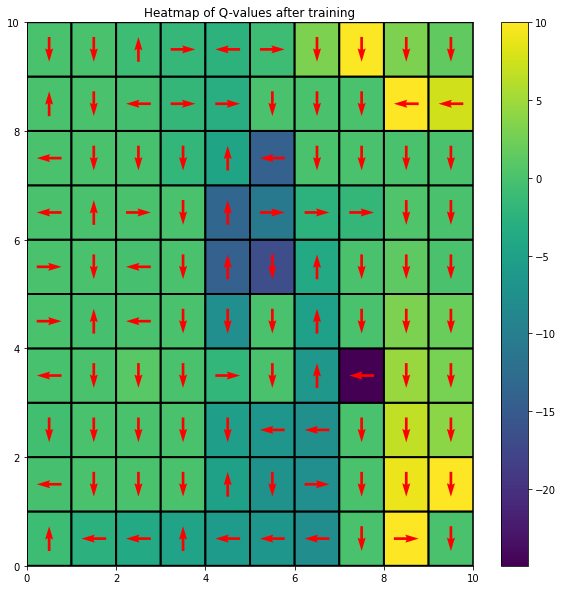

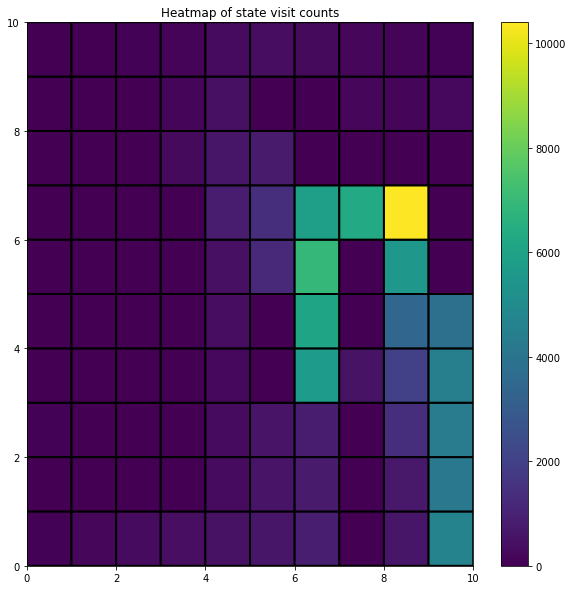

100%|██████████| 5000/5000 [00:11<00:00, 434.25it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 579.08it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 554.27it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:18<00:00, 276.53it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:17<00:00, 280.03it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:12<00:00, 403.37it/s]


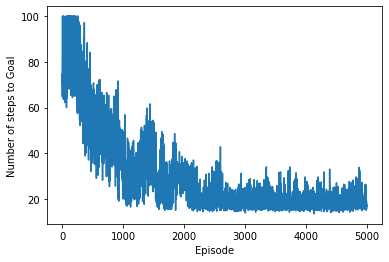

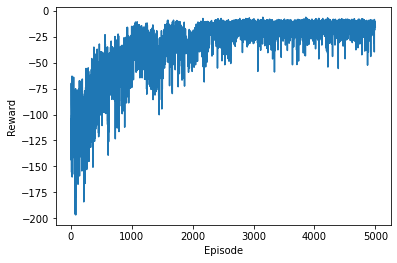

In [94]:
gamma=1
epslion=0.01
alpha=0.05
env=create_env(wind=True,p=1.0,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Start\:state=[3,6],\:ϵ-greedy\:exploration, Wind=False\:and\:p=0.7$

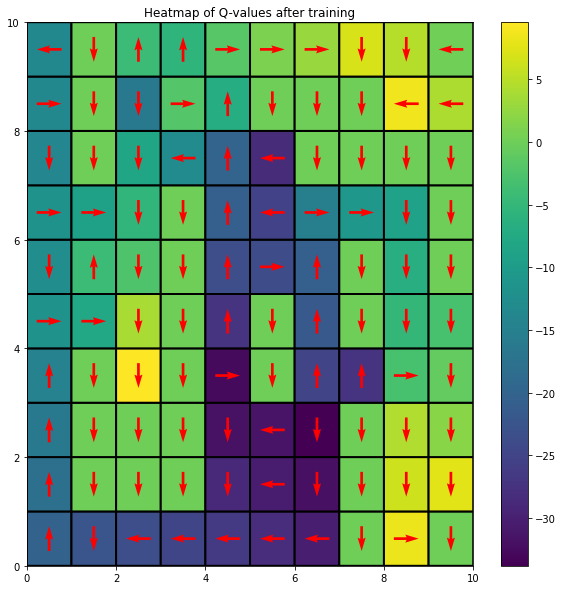

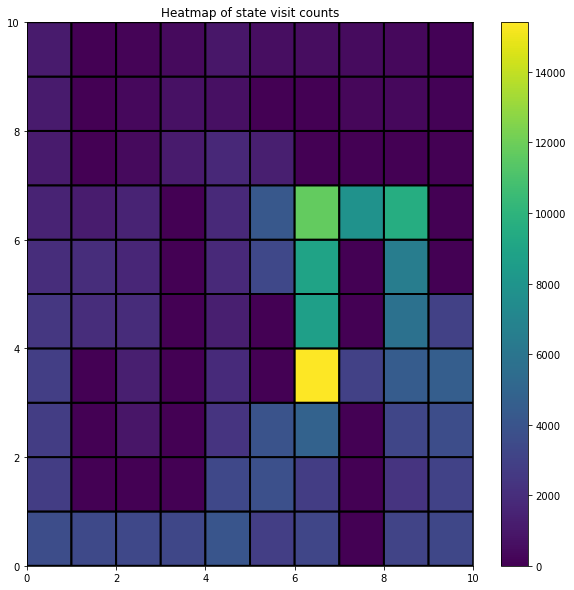

100%|██████████| 5000/5000 [00:18<00:00, 267.04it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 296.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:14<00:00, 339.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:14<00:00, 344.34it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:14<00:00, 344.80it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:14<00:00, 349.25it/s]


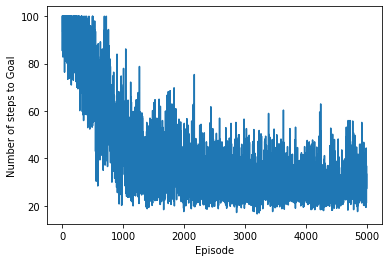

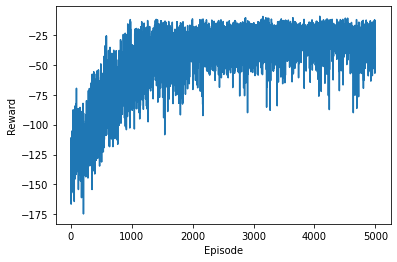

In [95]:
gamma=1
epslion=0.01
alpha=0.05
env=create_env(wind=False,p=0.7,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Start\:state=[3,6],\:ϵ-greedy\:exploration, Wind=False\:and\:p=1.0$

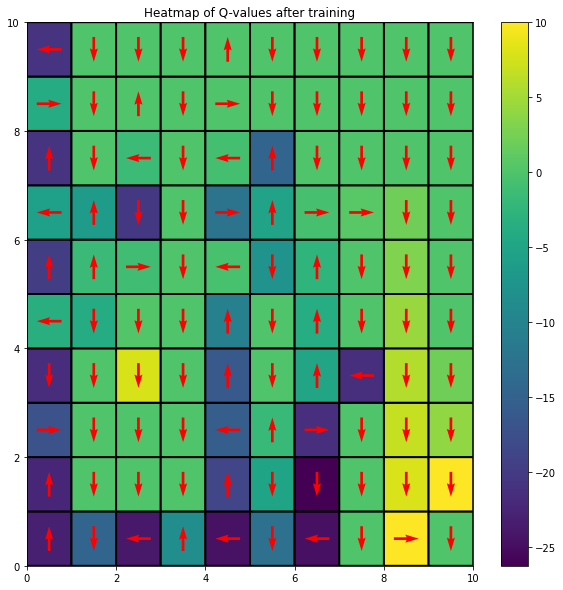

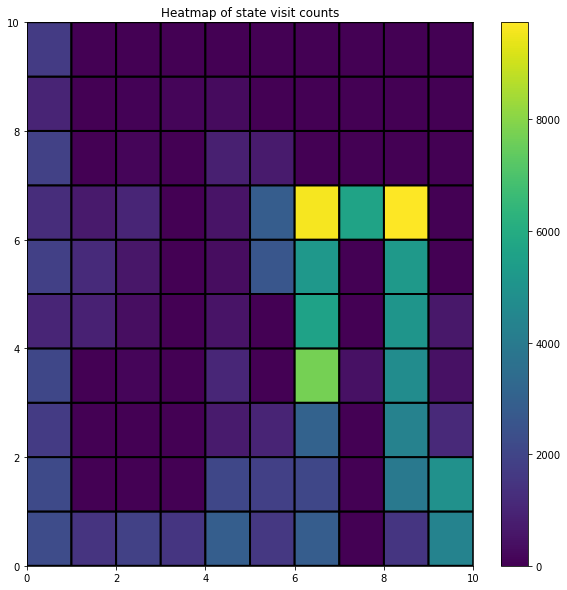

100%|██████████| 5000/5000 [00:12<00:00, 386.41it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 493.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 590.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 746.81it/s] 


Experiment: 4


100%|██████████| 5000/5000 [00:08<00:00, 597.67it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:15<00:00, 318.41it/s]


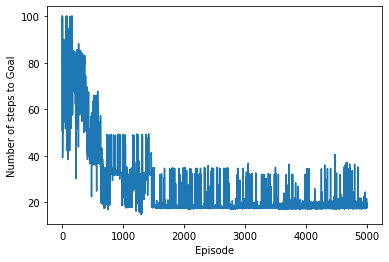

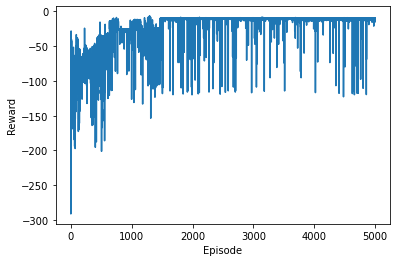

In [96]:
gamma=1
epslion=0.01
alpha=0.05
env=create_env(wind=False,p=1.0,start_state=[3,6])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Start\:state=[0,4],\:Softmax\:exploration, Wind=False\:and\:p=1$

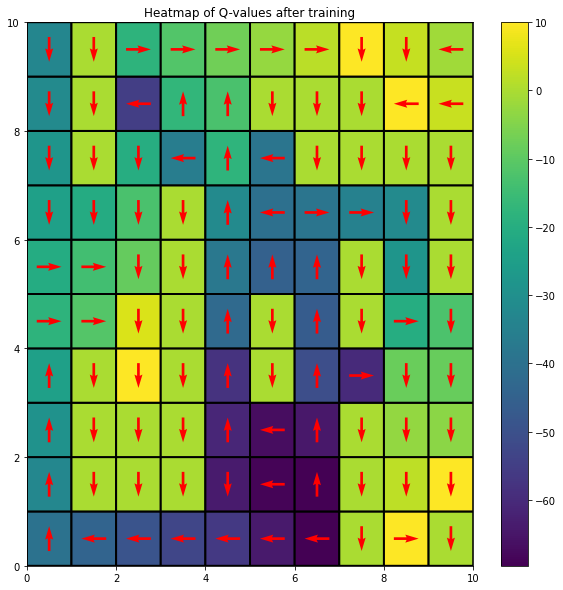

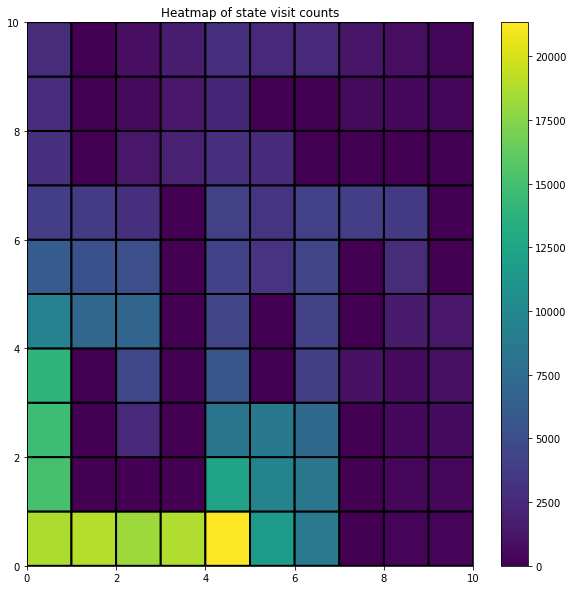

100%|██████████| 5000/5000 [01:00<00:00, 82.73it/s] 


Experiment: 1


100%|██████████| 5000/5000 [00:56<00:00, 87.73it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:57<00:00, 87.37it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:56<00:00, 88.44it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:56<00:00, 87.81it/s] 


Experiment: 5


100%|██████████| 5000/5000 [00:56<00:00, 88.15it/s] 


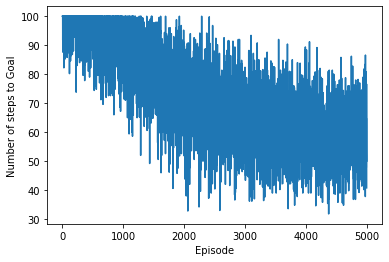

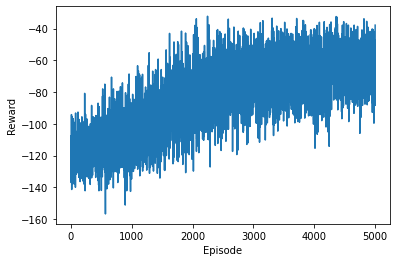

In [97]:
gamma=1
tau=10
alpha=0.05
env=create_env(wind=False,p=1,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')



#$Start\:state=[0,4],\:Softmax\:exploration, Wind=False\:and\:p=0.7$

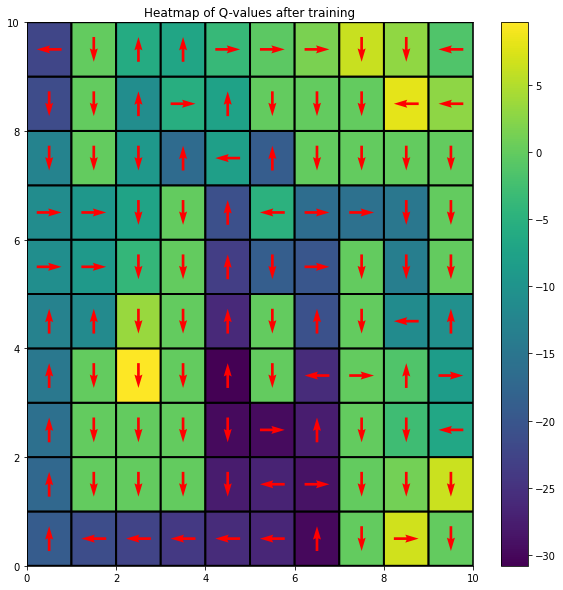

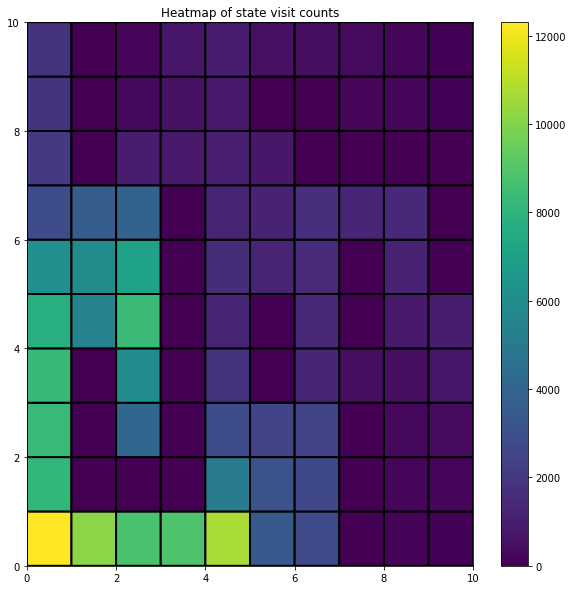

100%|██████████| 5000/5000 [00:33<00:00, 149.79it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:30<00:00, 164.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:32<00:00, 156.05it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:31<00:00, 156.35it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:29<00:00, 168.10it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:28<00:00, 173.75it/s]


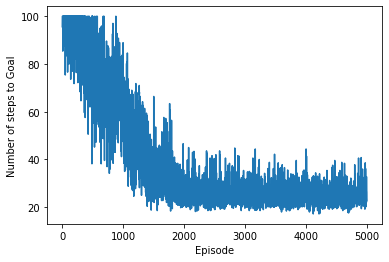

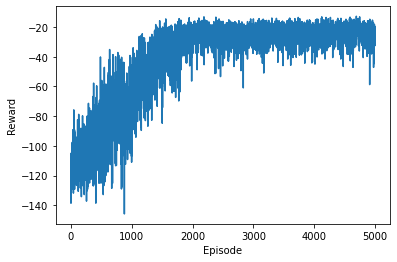

In [98]:
gamma=1
tau=0.1
alpha=0.05
env=create_env(wind=False,p=0.7,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')

#$Start\:state=[0,4],\:Softmax\:exploration, Wind=True\:and\:p=1$

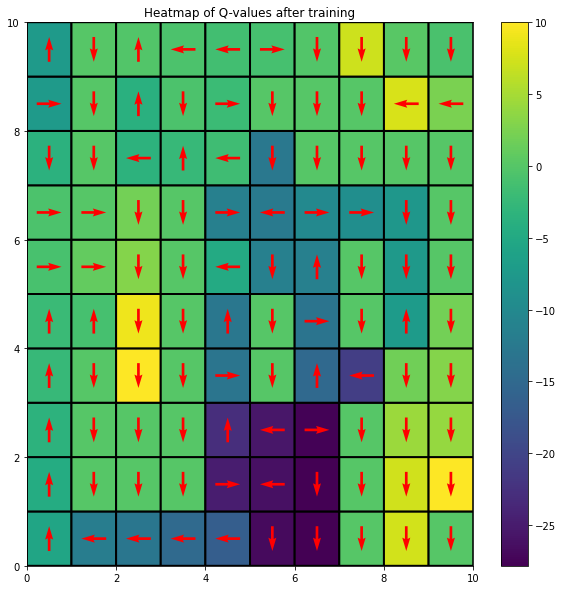

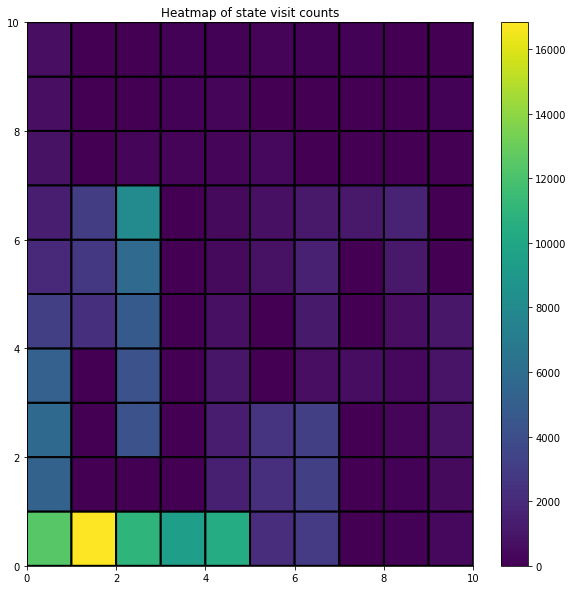

100%|██████████| 5000/5000 [00:29<00:00, 170.06it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:25<00:00, 193.58it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:24<00:00, 200.10it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:28<00:00, 173.93it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:28<00:00, 173.79it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:24<00:00, 200.44it/s]


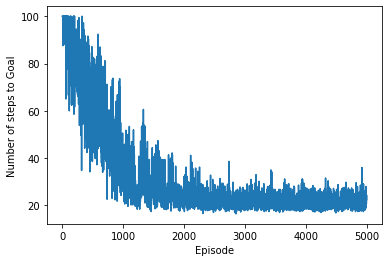

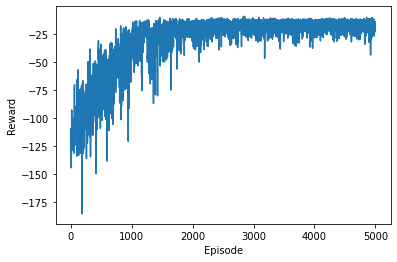

In [99]:
gamma=1
tau=0.1
alpha=0.05
env=create_env(wind=True,p=1,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')

#$Start\:state=[0,4],\:Softmax\:exploration, Wind=True\:and\:p=0.7$

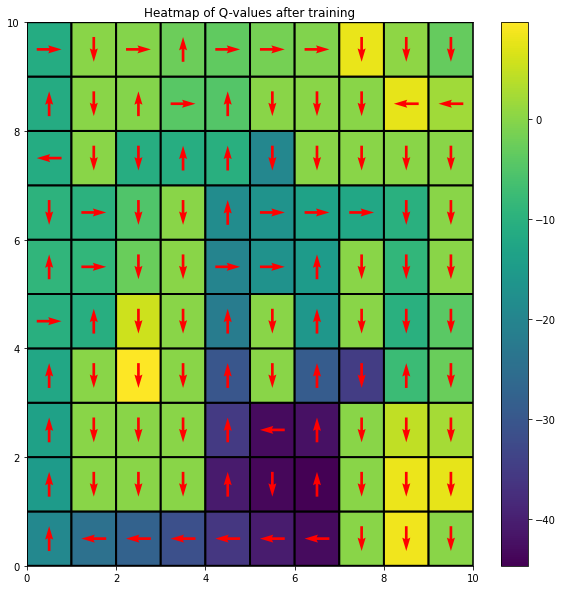

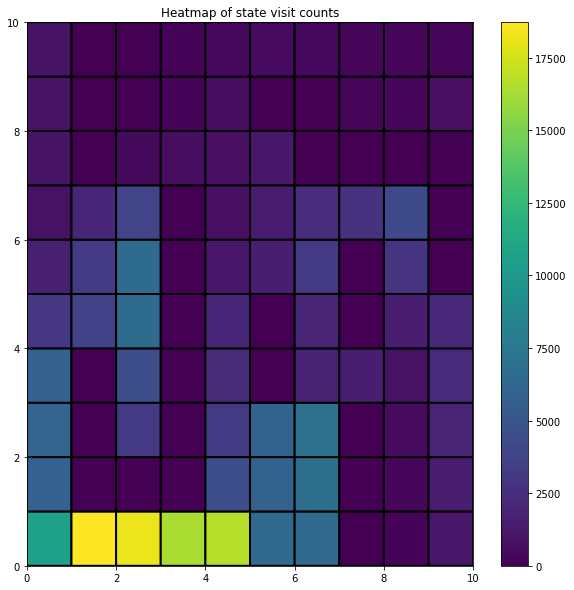

100%|██████████| 5000/5000 [00:41<00:00, 121.58it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:36<00:00, 137.80it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:35<00:00, 139.69it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:36<00:00, 136.06it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:37<00:00, 134.50it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:37<00:00, 133.91it/s]


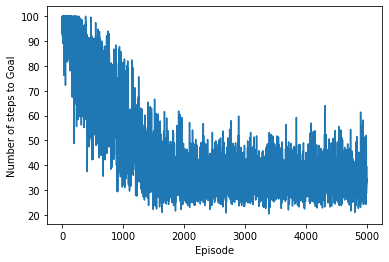

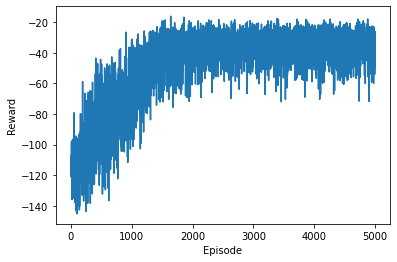

In [100]:
gamma=1
tau=0.1
alpha=0.05
env=create_env(wind=True,p=0.7,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, tau=tau,alpha0=alpha,plot_heat=True, strategy='softmax')
plot_curves(env, gamma = gamma, tau=tau,alpha0=alpha,strategy='softmax')

#$Start\:state=[0,4],\:ϵ-greedy\:exploration, Wind=True\:and\:p=0.7$

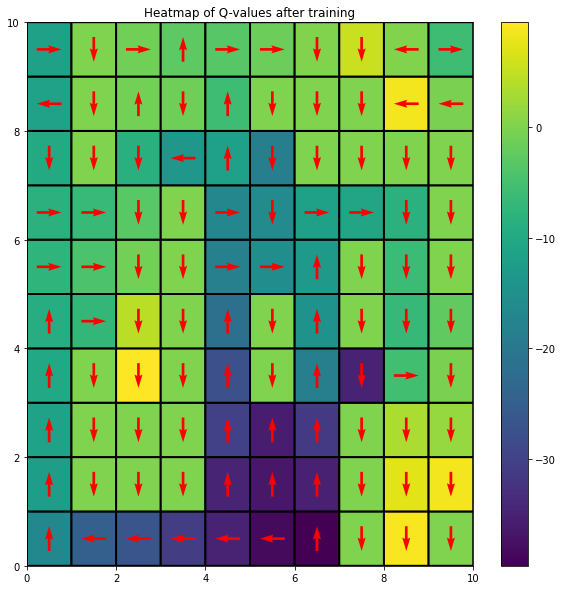

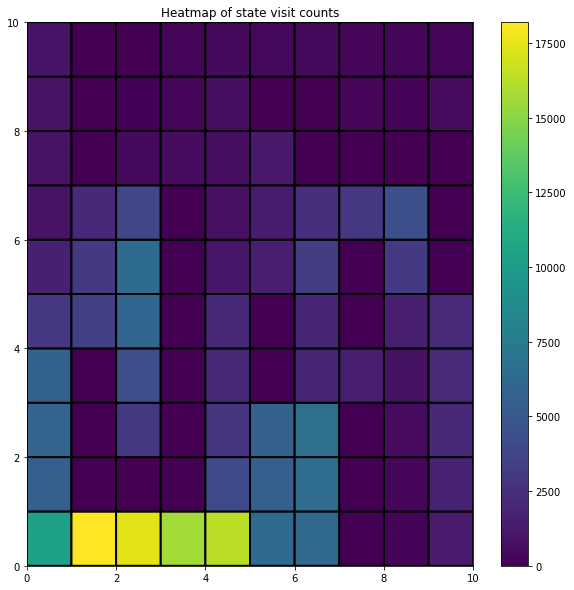

100%|██████████| 5000/5000 [00:19<00:00, 251.31it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 288.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:16<00:00, 304.68it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:17<00:00, 286.48it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:17<00:00, 293.16it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:17<00:00, 290.93it/s]


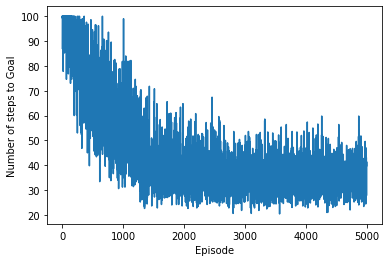

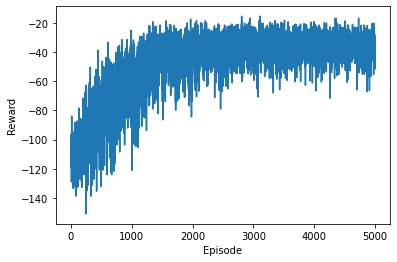

In [101]:
gamma=1
epsilon=0.01
alpha=0.05
env=create_env(wind=True,p=0.7,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Start\:state=[0,4],\:ϵ-greedy\:exploration, Wind=True\:and\:p=1.0$

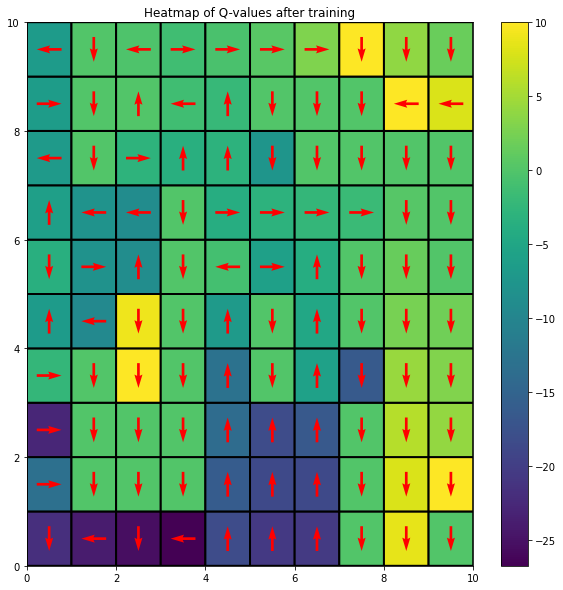

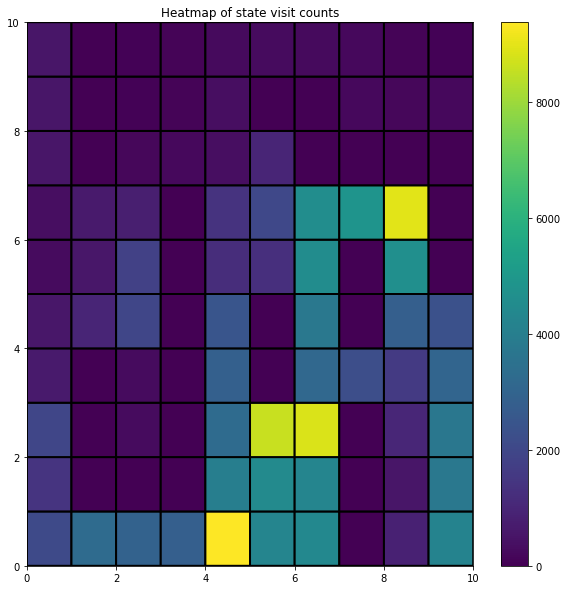

100%|██████████| 5000/5000 [00:15<00:00, 319.42it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 358.00it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:18<00:00, 274.59it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:13<00:00, 380.63it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:13<00:00, 362.97it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:13<00:00, 369.56it/s]


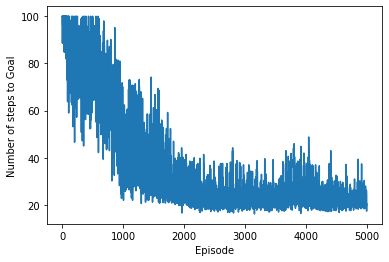

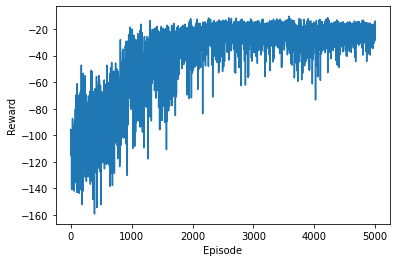

In [102]:
gamma=1
epslion=0.01
alpha=0.05
env=create_env(wind=True,p=1.0,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Start\:state=[0,4],\:ϵ-greedy\:exploration, Wind=False\:and\:p=0.7$

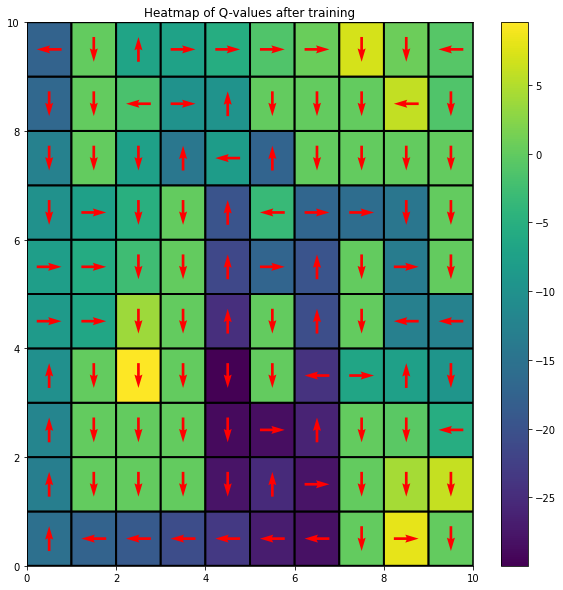

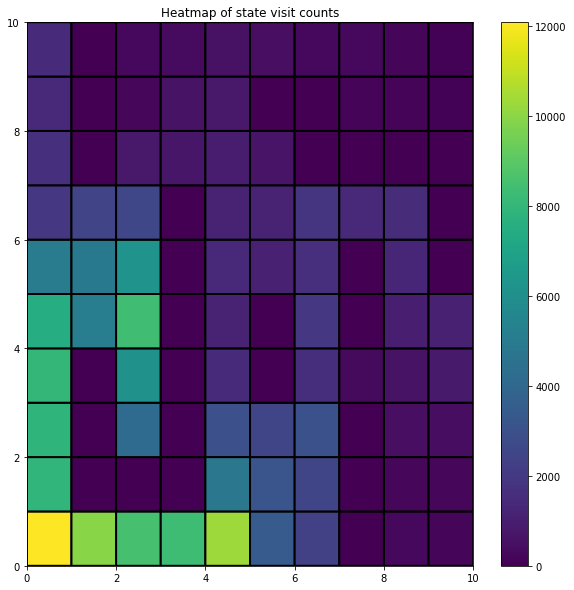

100%|██████████| 5000/5000 [00:15<00:00, 316.81it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 358.15it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 392.52it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 399.90it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:12<00:00, 389.91it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:12<00:00, 415.52it/s]


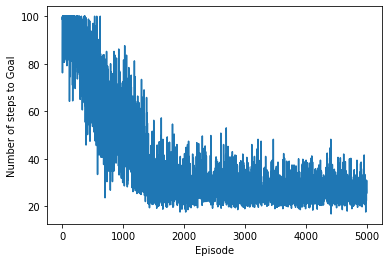

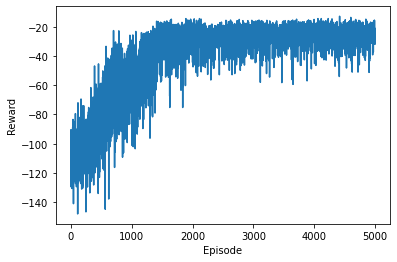

In [103]:
gamma=1
epslion=0.01
alpha=0.05
env=create_env(wind=False,p=0.7,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Start\:state=[0,4],\:ϵ-greedy\:exploration, Wind=False\:and\:p=1.0$

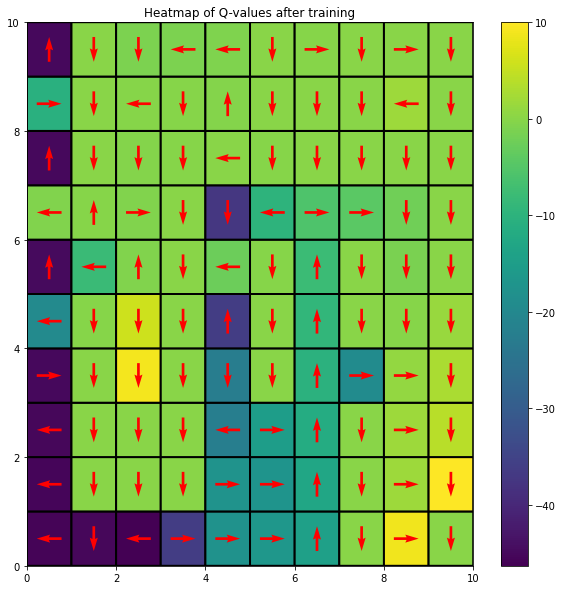

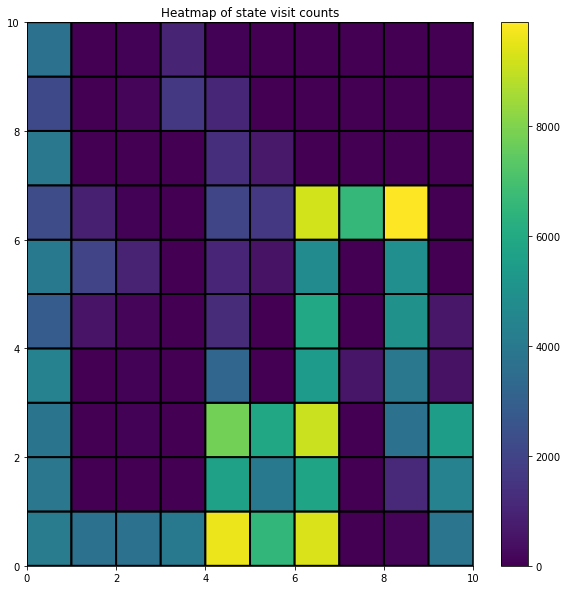

100%|██████████| 5000/5000 [00:17<00:00, 292.33it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 473.79it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 431.28it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:13<00:00, 372.11it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:12<00:00, 394.83it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:10<00:00, 470.06it/s]


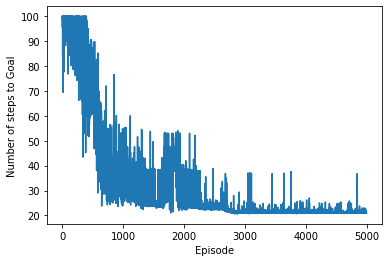

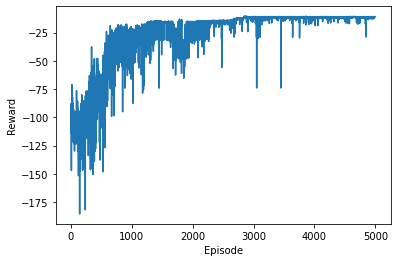

In [104]:
gamma=1
epslion=0.01
alpha=0.05
env=create_env(wind=False,p=1.0,start_state=[0,4])
Q = np.zeros((num_cols*num_rows, env.num_actions))
Q, rewards, steps = sarsa(env, Q, gamma = gamma, epsilon=epsilon,alpha0=alpha,plot_heat=True, strategy='epsilon')
plot_curves(env, gamma = gamma, epsilon=epsilon,alpha0=alpha,strategy='epsilon')

#$Rendering\:of\:the\:environment\:for\:a\:specific\:configuration$

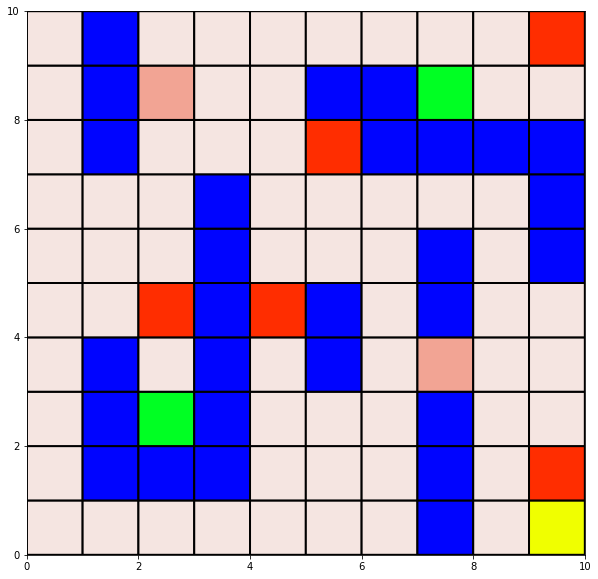

Steps: 41, Total Reward: -30


In [ ]:
from time import sleep

state = env.reset() #using previous environment, can also creat new environment
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done,_ = env.step(state,Q[state].argmax())
    plt.figure(figsize=(10, 10))
    env.render(state,ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))
#blue-obstruction;red-bad;peach-restart;yellow-current;green-goal

#$Grid\:Search\:for\:optimal\:hyperparameters\:for\:Softmax\:and\:no\:wind$





In [ ]:
tau_list=[1e-3,1e-2,0.1,1,10]
alpha_list=[1e-2,0.05,0.2]
gamma_list=[0,0.4,0.9,1]
history=[]

for tau in tau_list:
  for alpha in alpha_list:
    for gamma in gamma_list:
      Q = np.zeros((num_cols*num_rows, env.num_actions))
      _, rewards, steps = sarsa(env, Q,tau=tau,alpha0=alpha,gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
      dic={'tau':tau,'alpha':alpha,'gamma':gamma,'rewards':rewards,'steps':steps}
      history.append(dic) 

100%|██████████| 5000/5000 [00:51<00:00, 96.39it/s] 


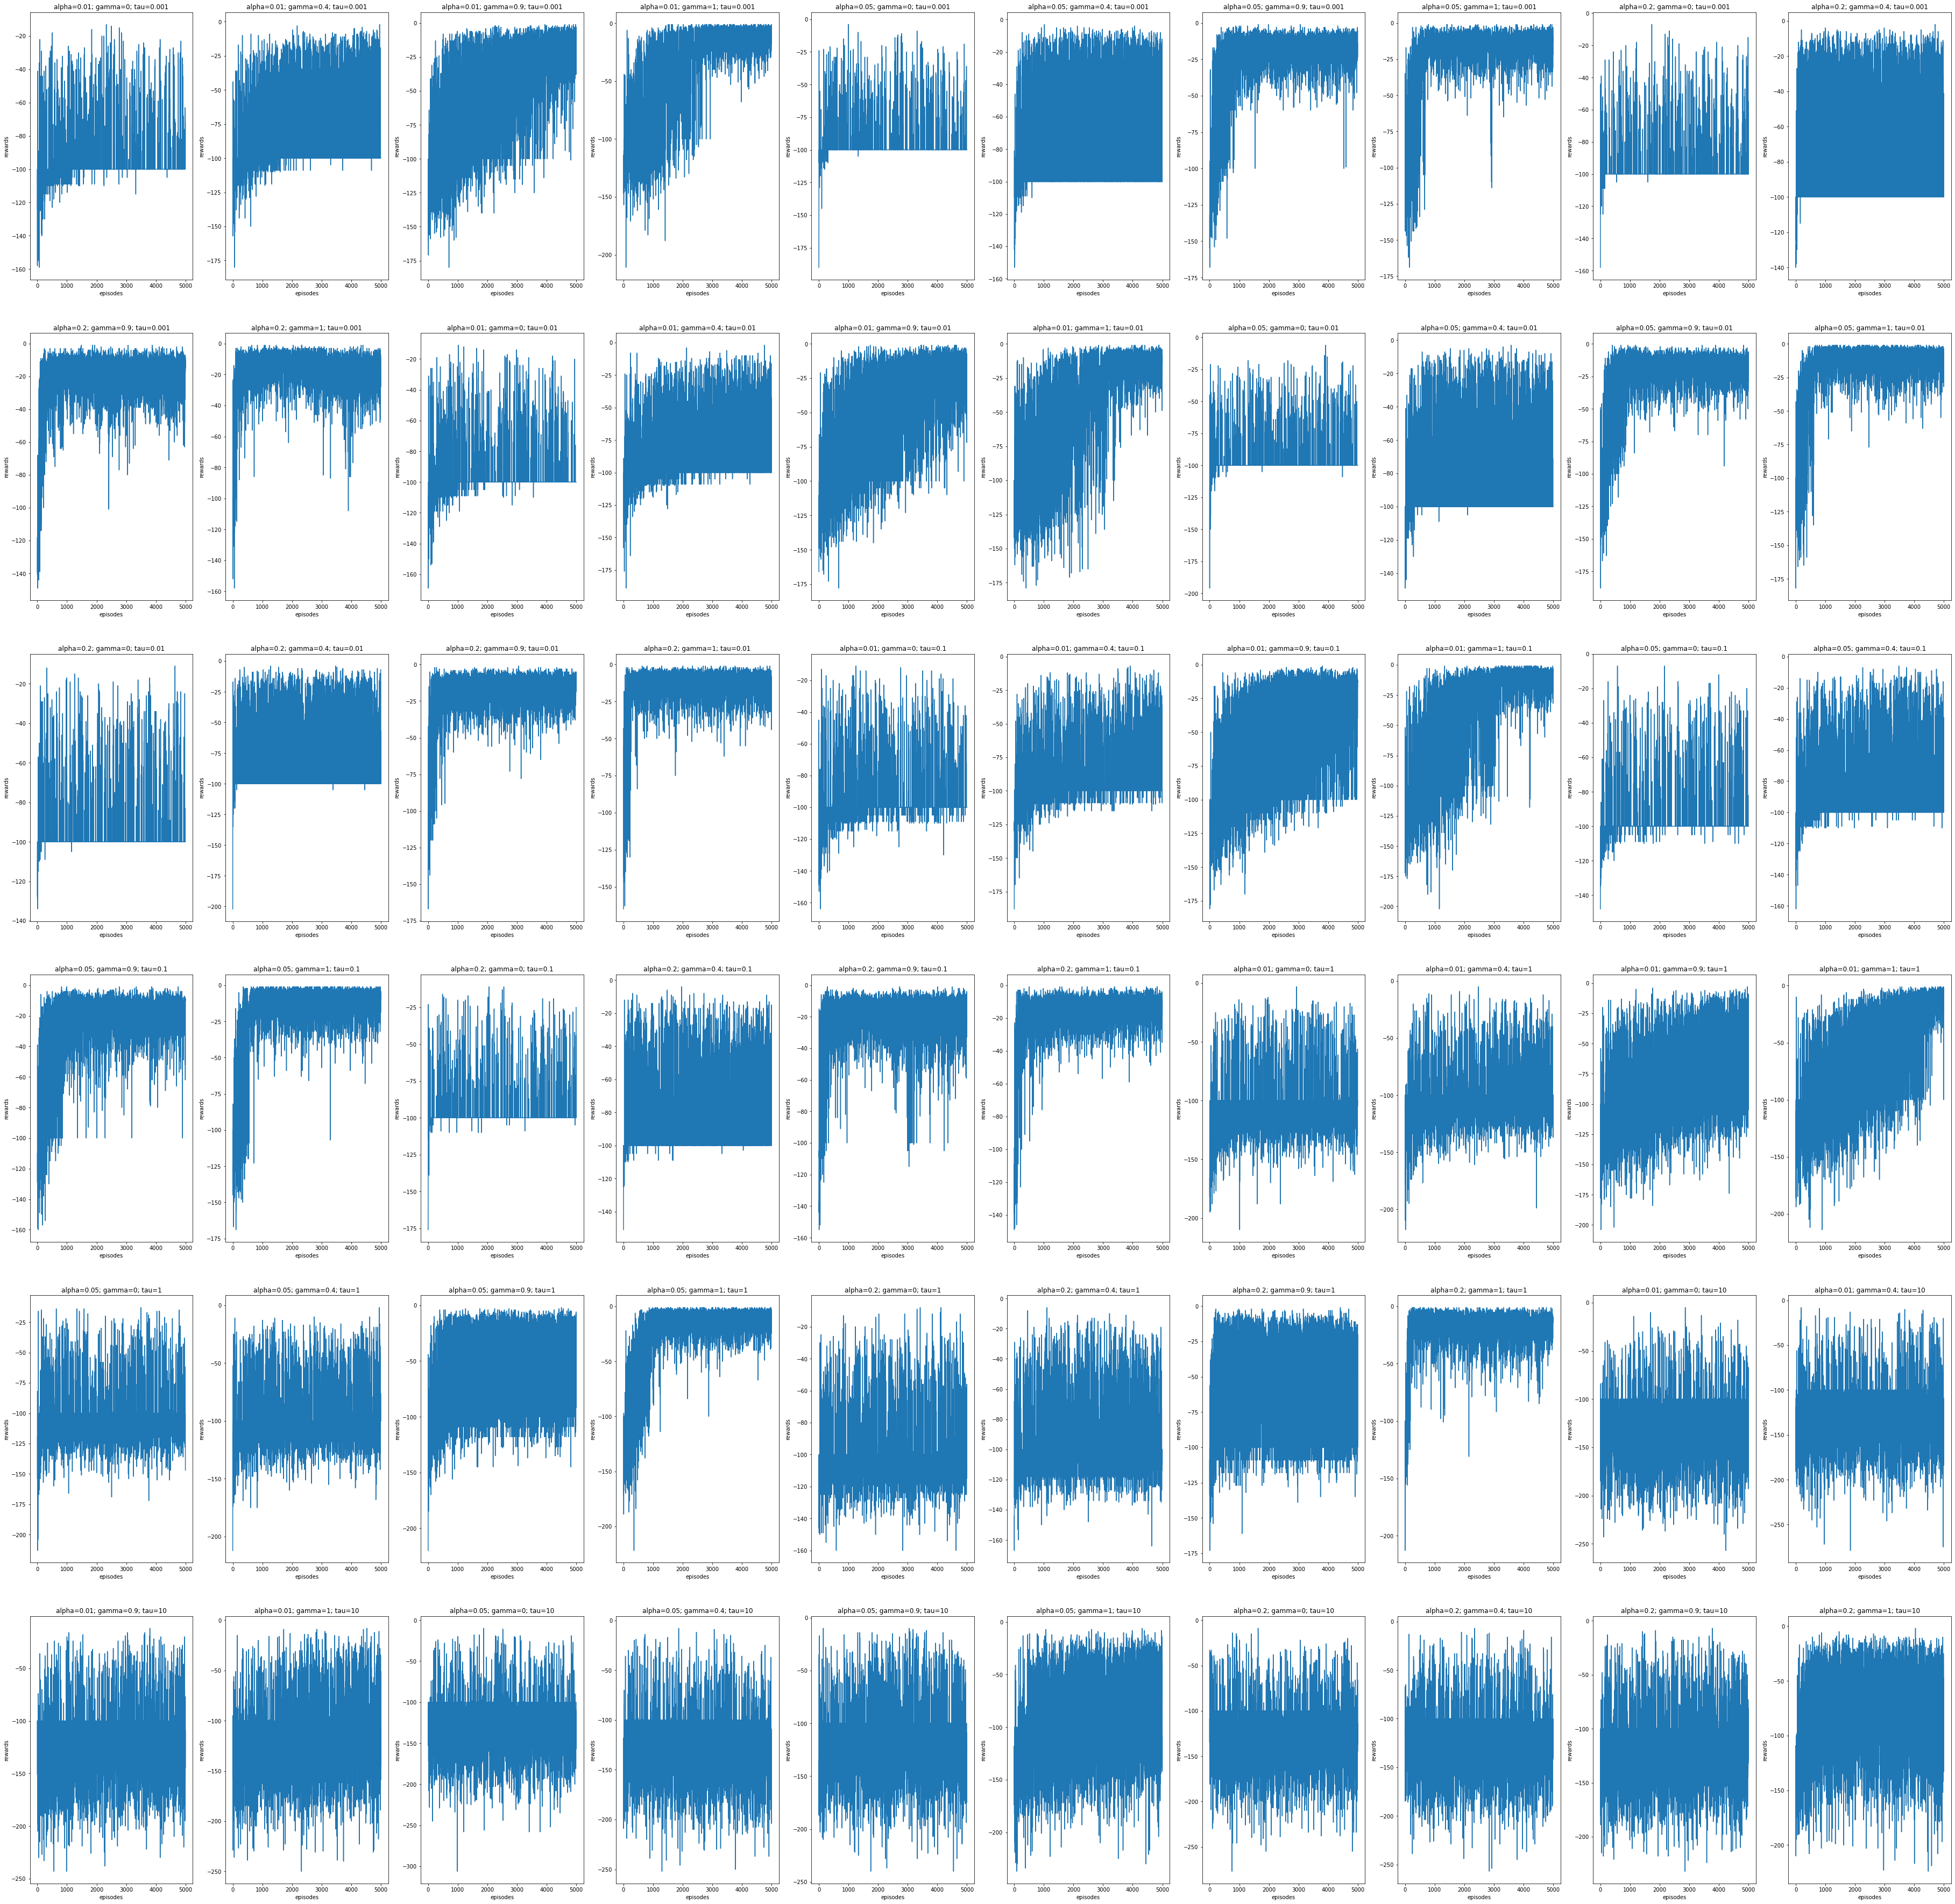

In [ ]:
fig,axs=plt.subplots(nrows=6,ncols=10,figsize=(64,64))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(hspace=0.2)
for config,ax in zip(history,axs.ravel()):
  alpha=config['alpha']
  gamma=config['gamma']
  tau=config['tau']
  ax.plot(np.arange(episodes),config['rewards'])
  ax.set_title(f'alpha={alpha}; gamma={gamma}; tau={tau}')
  ax.set_xlabel('episodes')
  ax.set_ylabel('rewards') #reward plot

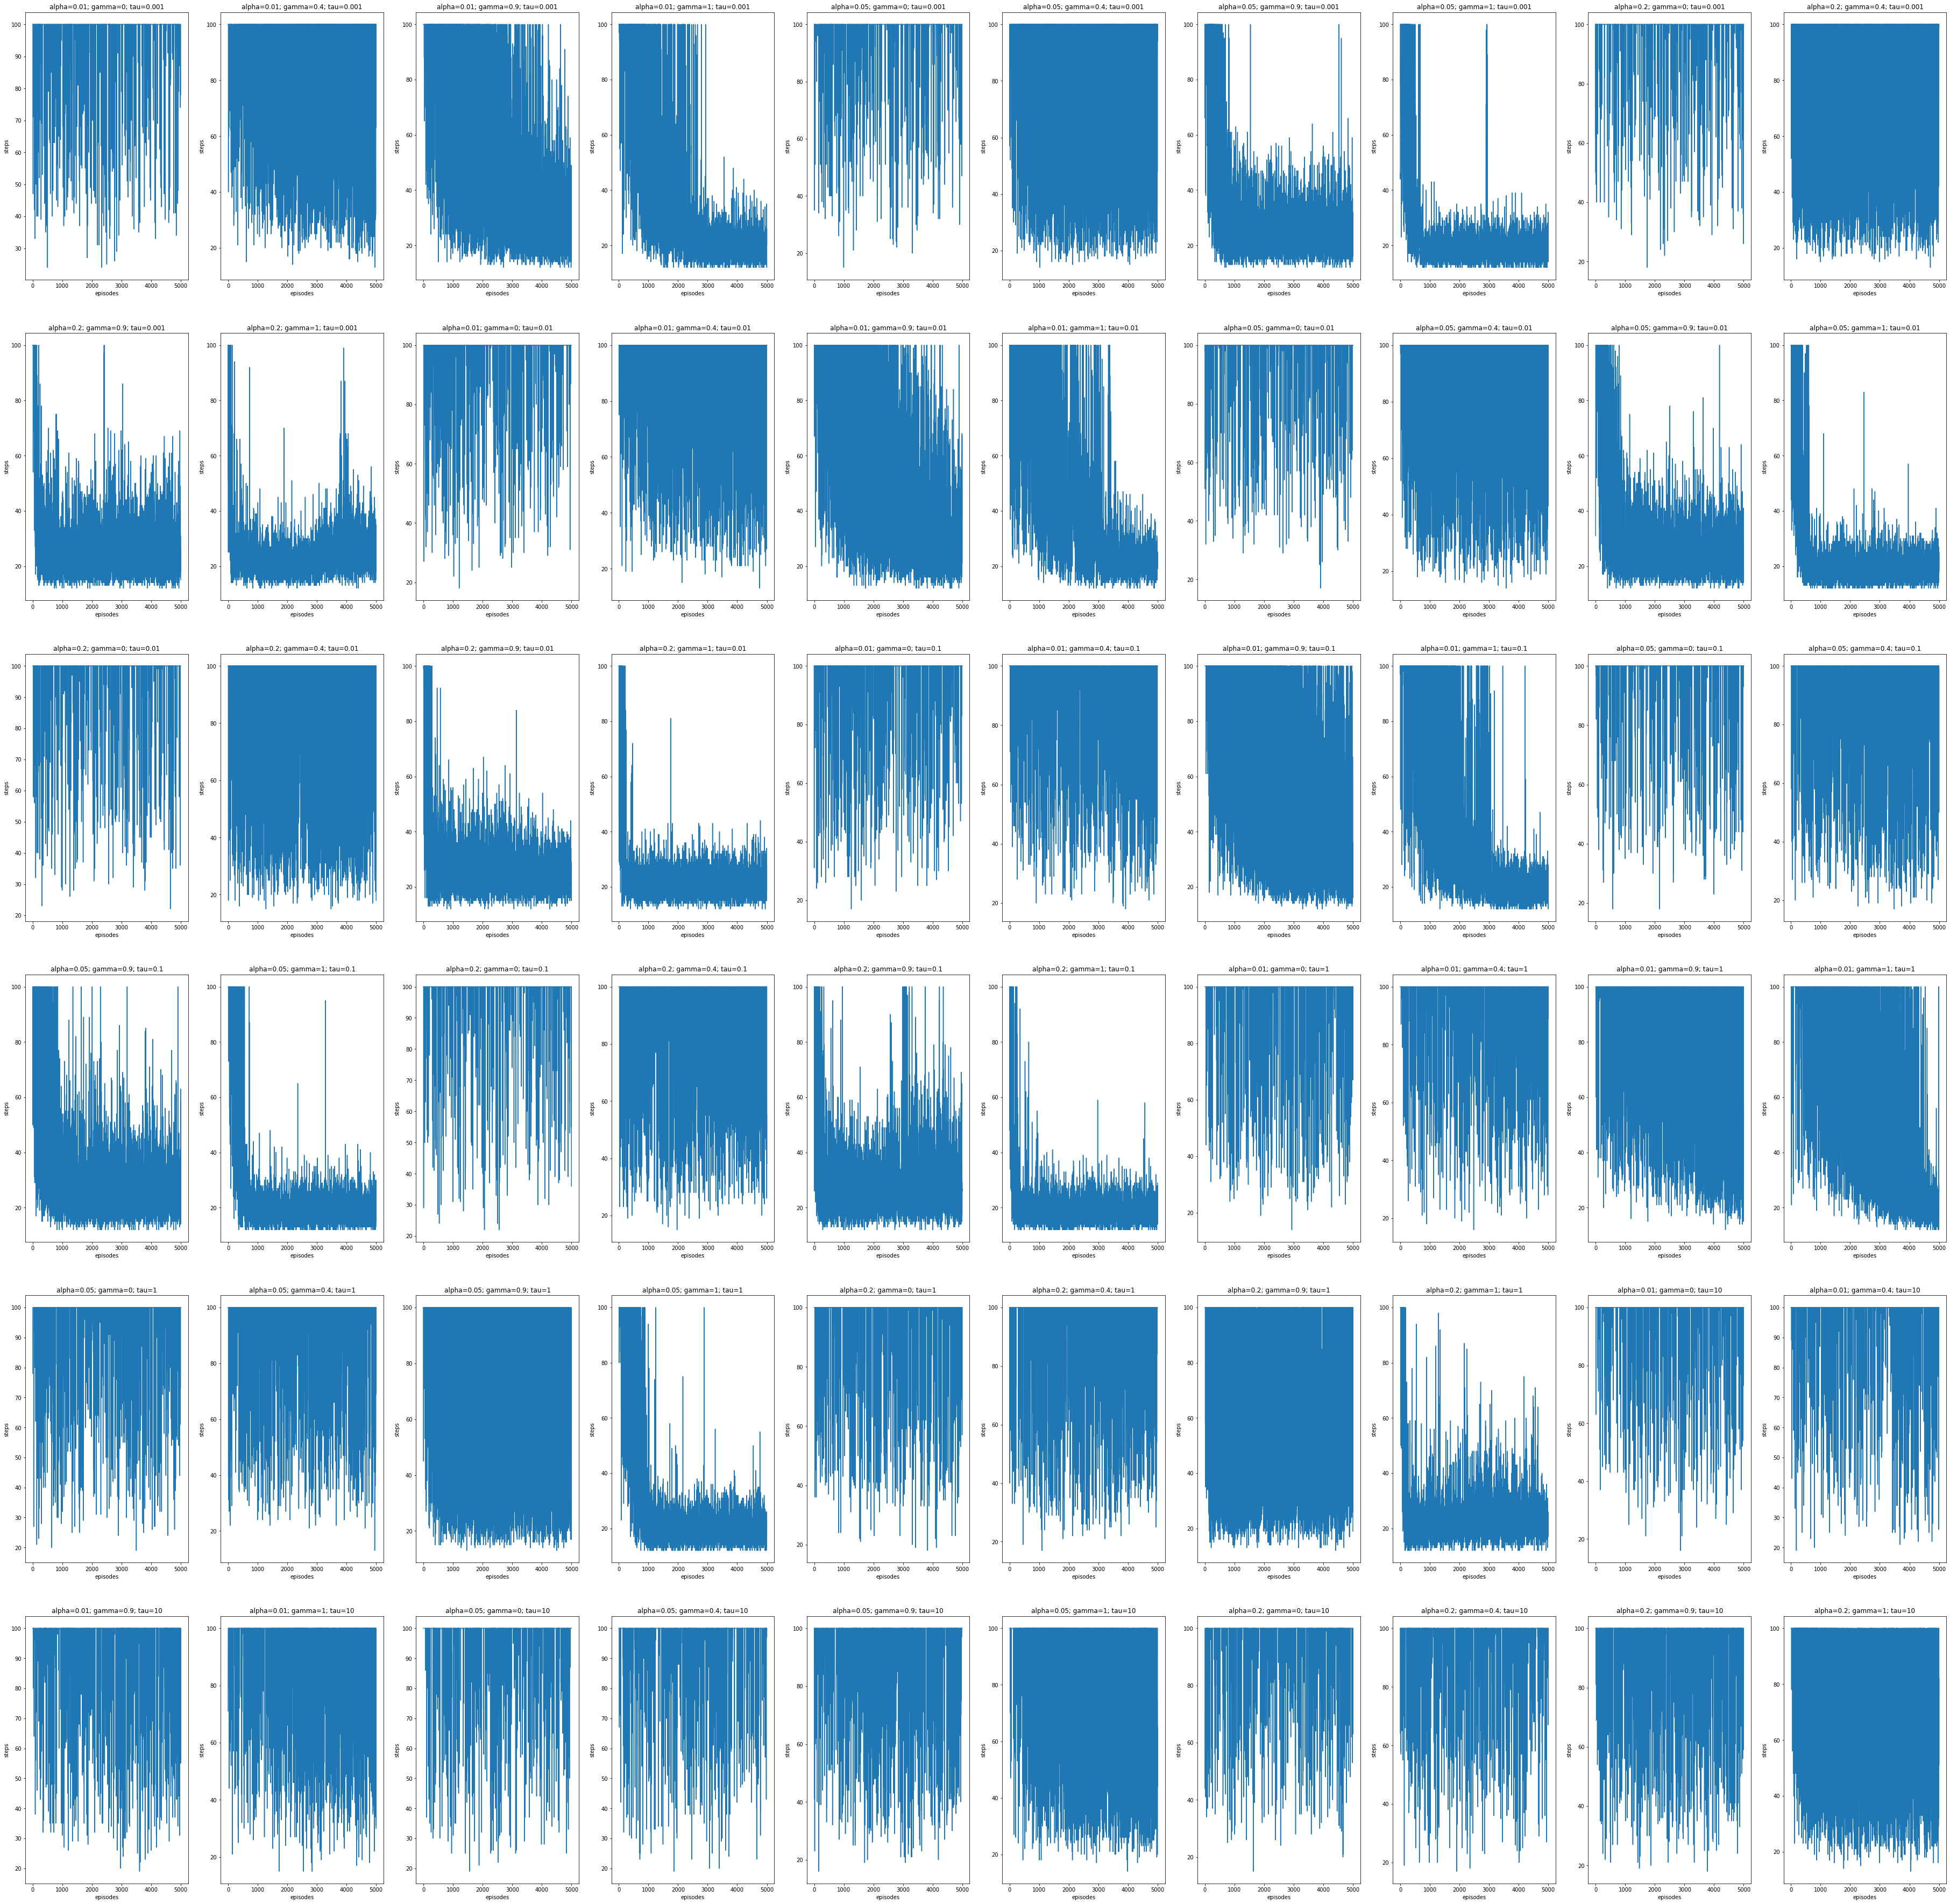

In [ ]:
fig,axs=plt.subplots(nrows=6,ncols=10,figsize=(64,64))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(hspace=0.2)
for config,ax in zip(history,axs.ravel()):
  alpha=config['alpha']
  gamma=config['gamma']
  tau=config['tau']
  ax.plot(np.arange(episodes),config['steps'])
  ax.set_title(f'alpha={alpha}; gamma={gamma}; tau={tau}')
  ax.set_xlabel('episodes')
  ax.set_ylabel('steps')  #plot for no.of steps

#$Grid\:Search\:for\:optimal\:hyperparameters\:for\:\ ϵ-greedy\:and\:wind$





In [ ]:

epsilon_list=[0.01,0.05,0.1,0.4]
alpha_list=[1e-2,0.05,0.2]
gamma_list=[0,0.4,0.9,1]
history=[]

for epsilon in epsilon_list:
  for alpha in alpha_list:
    for gamma in gamma_list:
      Q = np.zeros((num_cols*num_rows, env.num_actions))
      _, rewards, steps = sarsa(env, Q,epsilon=epsilon,alpha0=alpha,gamma = gamma, plot_heat=False, choose_action= choose_action_epsilon)
      dic={'epsilon':epsilon,'alpha':alpha,'gamma':gamma,'rewards':rewards,'steps':steps}
      history.append(dic) 

100%|██████████| 5000/5000 [00:16<00:00, 303.86it/s]


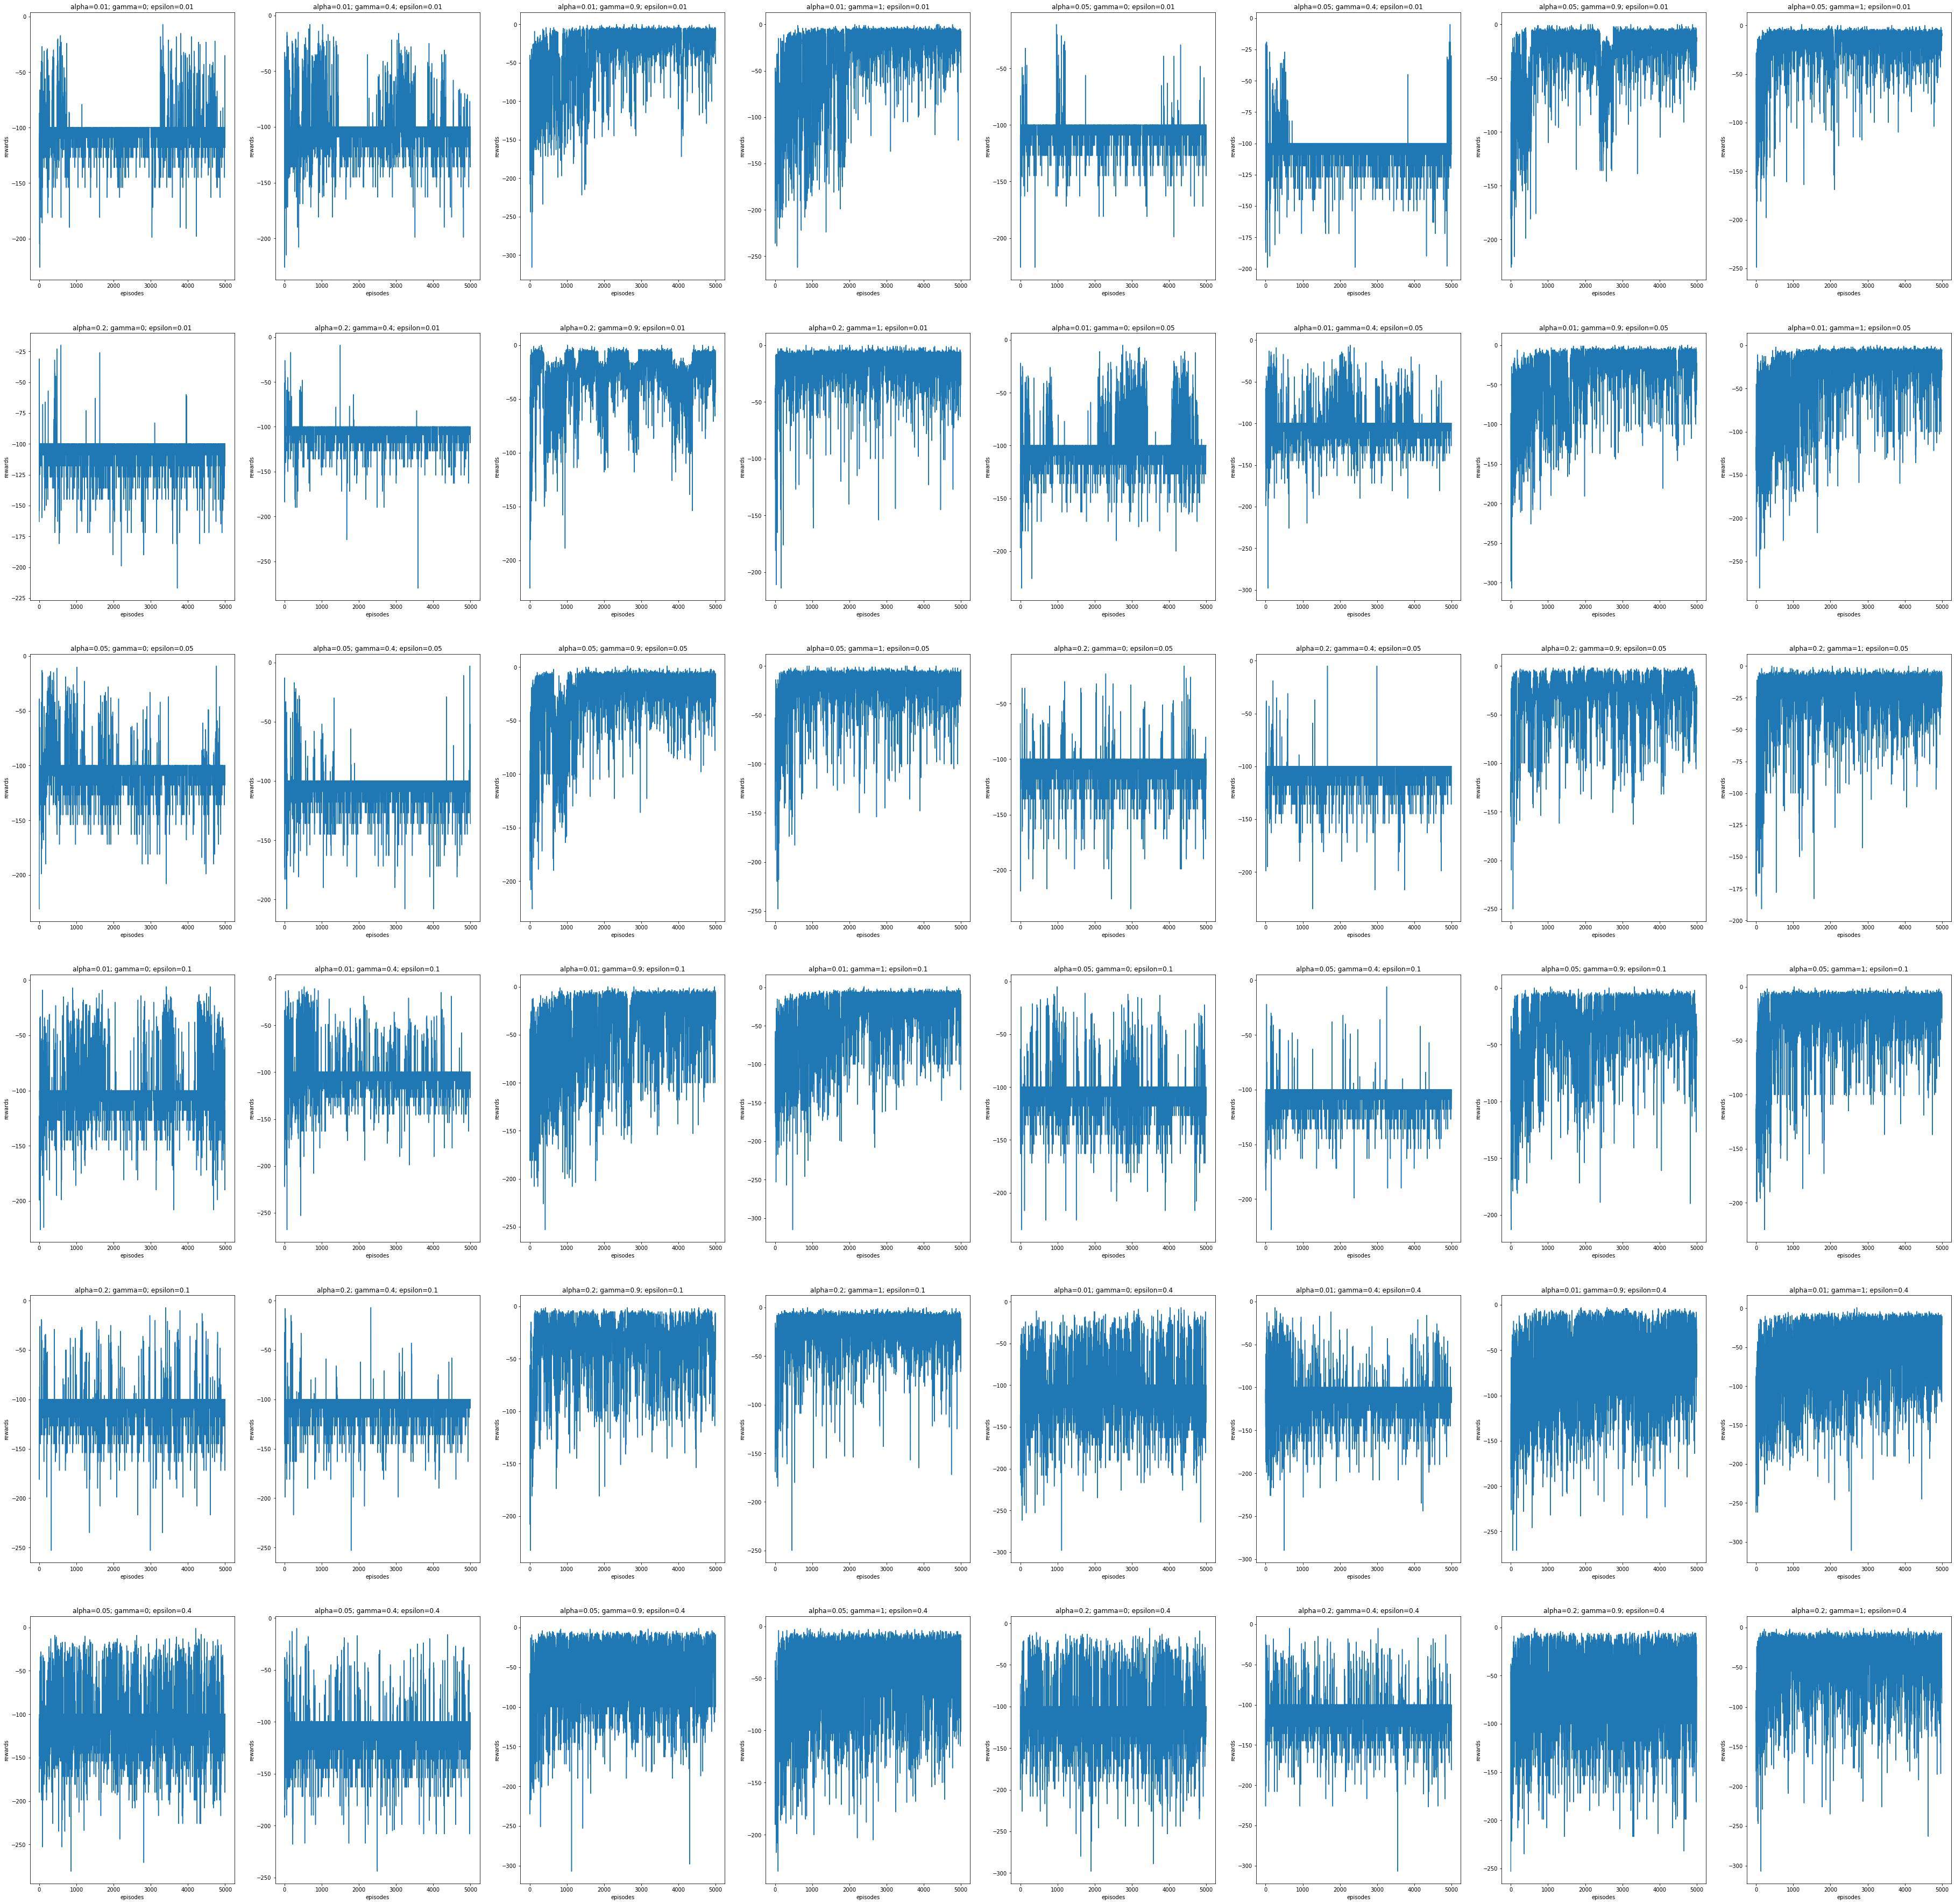

In [ ]:
fig,axs=plt.subplots(nrows=6,ncols=8,figsize=(64,64))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(hspace=0.2)
for config,ax in zip(history,axs.ravel()):
  alpha=config['alpha']
  gamma=config['gamma']
  epsilon=config['epsilon']
  ax.plot(np.arange(episodes),config['rewards'])
  ax.set_title(f'alpha={alpha}; gamma={gamma}; epsilon={epsilon}')
  ax.set_xlabel('episodes')
  ax.set_ylabel('rewards') #reward curve

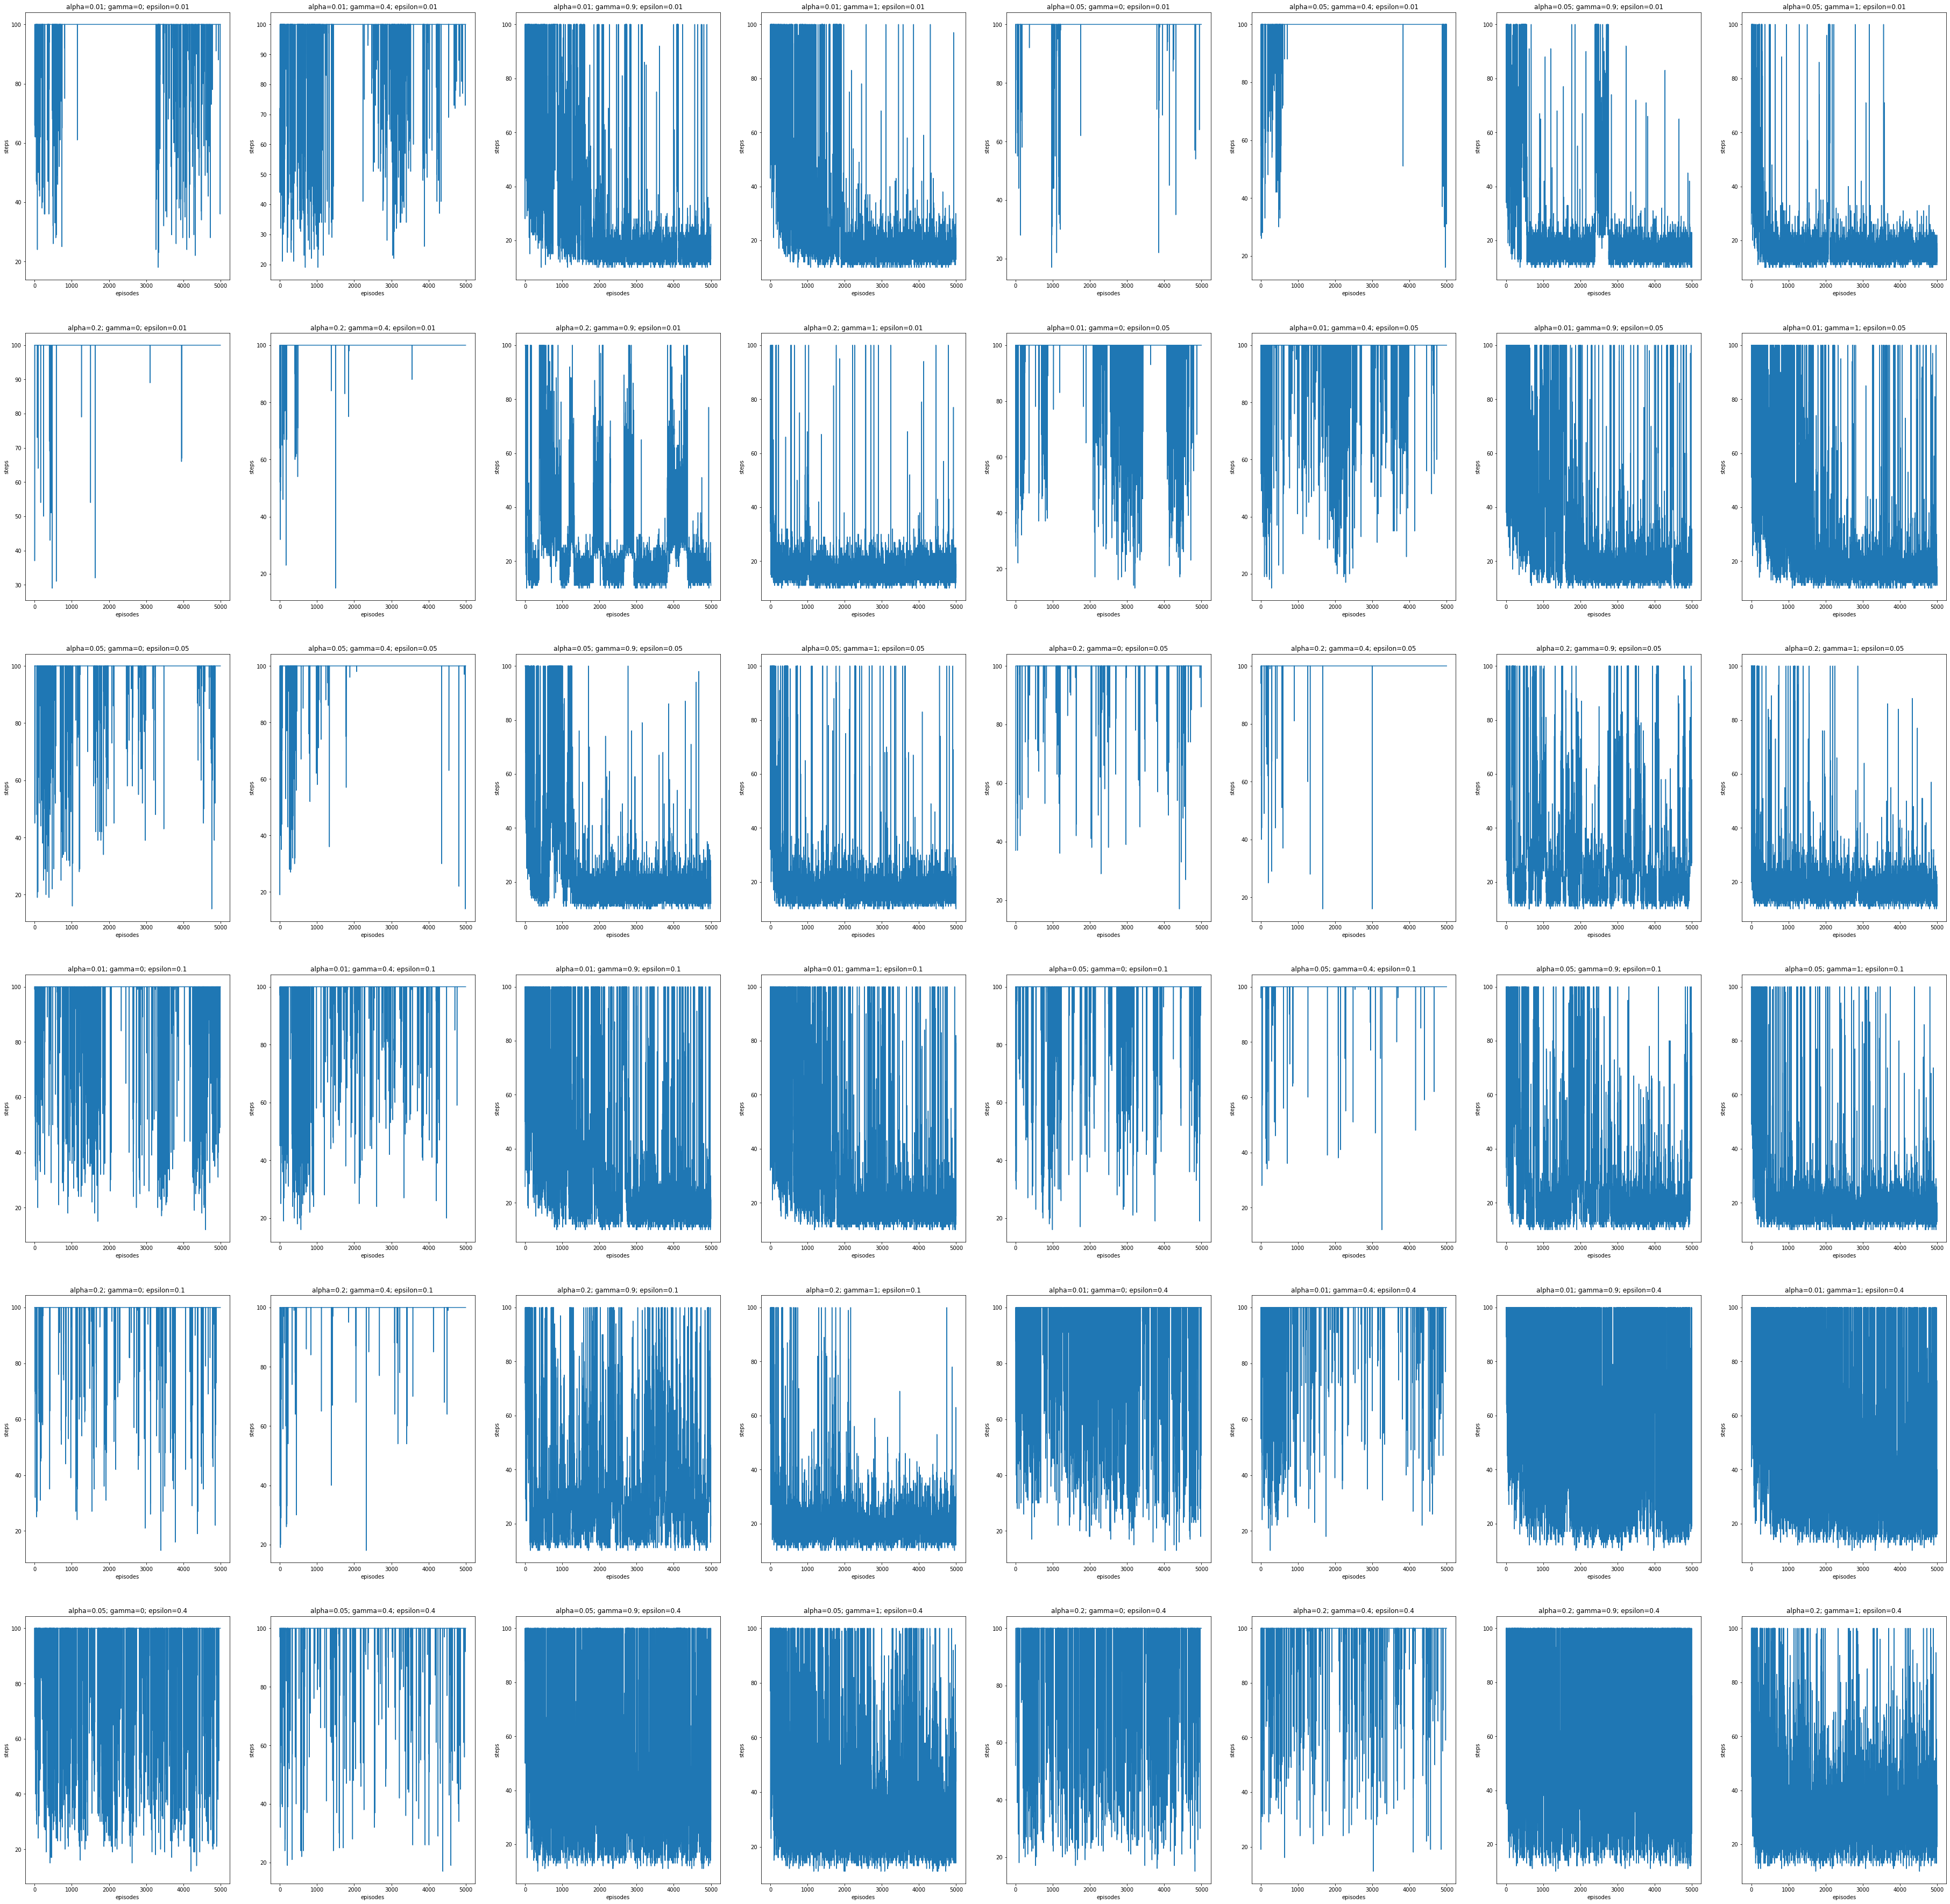

In [ ]:
fig,axs=plt.subplots(nrows=6,ncols=8,figsize=(64,64))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(hspace=0.2)
for config,ax in zip(history,axs.ravel()):
  alpha=config['alpha']
  gamma=config['gamma']
  epsilon=config['epsilon']
  ax.plot(np.arange(episodes),config['steps'])
  ax.set_title(f'alpha={alpha}; gamma={gamma}; epsilon={epsilon}')
  ax.set_xlabel('episodes')
  ax.set_ylabel('steps') #plot for no.of steps